## Bank Customer Segmentation
<h2 style="font-weight:bold; font-family:sans-serif"><b>Goal of creating this Notebook</h2>

1. Perform Clustering / Segmentation on the dataset and identify popular customer groups along with their definitions/rules
2. Perform Location-wise analysis to identify regional trends in India
3. Perform transaction-related analysis to identify interesting trends that can be used by a bank to improve / optimi their user experiences
4. Customer Recency, Frequency, Monetary analysis

**Table of contents of this notebook:**

**1.** Importing Necessary Libraries<br>
**2.** Data Collection<br>
**3.** Data Cleaning<br>
**4.** Exploratory Data Analysis

## 1. Importing Libraries

In [5]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from scipy.stats import probplot
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from datetime import date
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Data Collection

In [7]:
def import_data():
    """
    Imports our relative path Dataset and in addition to that, renames the TransactionAmount (INR) column in TransactionAmount, 
    this in order to avoid that in the future the special characters of the original name give us problems.
    
    Returns:
        DataFrame: dfGet source data
    """
    #dfGet = pd.read_csv("/content/drive/MyDrive/bank_transactions.csv")
    dfGet = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bank_transactions.csv")
    dfGet = dfGet.rename(columns={'TransactionAmount (INR)':'TransactionAmount'})
    return dfGet
df = import_data()
# Showing or Checking results
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [8]:
def dfInformation(dataframe):
    """
    Gets the initial information of the Dataset, the number of records, number of variables, non-null objects and data type.

    Args:
        dataframe (DataFrame): Source dataset.
    
    Returns:
        void: A range indes conforma by float64(2), int64(1), object(6)

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    display(dataframe.info())
dfInformation(df)
# Getting the dataframe size for following amortized values
initialRows = len(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   TransactionID       1048567 non-null  object 
 1   CustomerID          1048567 non-null  object 
 2   CustomerDOB         1045170 non-null  object 
 3   CustGender          1047467 non-null  object 
 4   CustLocation        1048416 non-null  object 
 5   CustAccountBalance  1046198 non-null  float64
 6   TransactionDate     1048567 non-null  object 
 7   TransactionTime     1048567 non-null  int64  
 8   TransactionAmount   1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


None

## 3. Data Cleaning

In [9]:
def check(dataframe):
    """
    Gets the amount of null data and unique is calculated

    Args:
        dataframe (DataFrame): Source dataset.

    Returns:
        DataFrame: A new Dataframe tha represents de amortized values of null and unique values for each column.

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    l=[]
    columns=dataframe.columns
    for col in columns:
        dtypes=dataframe[col].dtypes
        nunique=dataframe[col].nunique()
        sum_null=dataframe[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['Column','Types','Unique','Nulls']
    return df_check 
check(df)

,Column,Types,Unique,Nulls
0,TransactionID,object,1048567,0
1,CustomerID,object,884265,0
2,CustomerDOB,object,17254,3397
3,CustGender,object,3,1100
4,CustLocation,object,9355,151
5,CustAccountBalance,float64,161328,2369
6,TransactionDate,object,55,0
7,TransactionTime,int64,81918,0
8,TransactionAmount,float64,93024,0


<b>Observation:</b><h6>The amount of null values to eliminate is equal to 6953 data, we eliminate these values because they do not represent more than 0.7% of the total data. <br> We check if there are repeated elements in our DataSet</h6>

In [10]:
def removeNullValues(dataframe):
    """
    Removes null values from data source and calculates the amount eliminated

    Args:
        dataframe (DataFrame): Source dataset.

    Returns:
        int: The total of null values already deleted

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    shapeInitial = dataframe.shape[0]
    dataframe.dropna(inplace=True)
    return shapeInitial-dataframe.shape[0]

print("Amount to remove " + str(removeNullValues(df)))

Amount to remove 6953


In [11]:
def checkDuplicates(dataframe):
    """
    Checks duplicated values for each column and amortized this count.

    Args:
        dataframe (DataFrame): Source dataset.

    Returns:
        int: The total of duplicated values in an specifica dataframe

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    return dataframe.duplicated().sum()
checkDuplicates(df)

0

<b>Consideration</b>
<h6>The CustomerDOB column is analyzed because it may contain atypical data.
<br>
We analyze the number of records for each client's date of birth.</h6>

In [12]:
def uniqueRows(dataframe, column):
    """
    Getting distinct values from column or specific variable

    Args:
        dataframe (DataFrame): Source dataset.
        column (string): Variable or column in dataframe

    Returns:
        Series: A series containing counts of unique rows in the DataFrame.

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    return dataframe[column].value_counts()
uniqueRows(df,'CustomerDOB')

1/1/1800    56292
1/1/89        809
1/1/90        784
6/8/91        698
1/1/91        665
            ...  
2/12/51         1
20/3/52         1
26/9/47         1
4/10/41         1
24/10/44        1
Name: CustomerDOB, Length: 17233, dtype: int64

<b>Take in mind</b>
<h6>Dates 1/1/1800 are deleted because it is not possible to define whether they are children, adults or persons without date of birth. This is an important variable for the business, for this reason we cannot make assumptions that bias the project, for this reason, it is better to eliminate these outliers or erroneously measured data.</h6>

In [13]:
def removeValues(dataframe,column, value):
    """
    Removes an specific value from a source column in a dataframe

    Args:
        dataframe (DataFrame): Source dataset.
        column (string): Variable or column in dataframe
        value (any): Value with column type

    Returns:
        DataFrame: A pandas DataFrame already modified.

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    return dataframe.loc[~(dataframe[column] == value)]

df = removeValues(df,'CustomerDOB','1/1/1800')
# Cheking distinct values from dataframe
uniqueRows(df,'CustomerDOB')

1/1/89      809
1/1/90      784
6/8/91      698
1/1/91      665
1/1/92      631
           ... 
23/2/05       1
28/11/42      1
23/9/49       1
14/3/40       1
24/10/44      1
Name: CustomerDOB, Length: 17232, dtype: int64

In [14]:
def minAndMax(dataframe, column):
    """
    Gets the minimum and maximum values of any column in order to see in which range the values in this column oscillate.

    Args:
        dataframe (DataFrame): Source dataset.
        column (string): Variable or column in dataframe

    Returns:
        void: Shows the minimun and maximun values from this column

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    print("min: " + str(dataframe[column].min()) + " max: " + str(dataframe[column].max()))
minAndMax(df,'CustomerDOB')

min: 1/1/00 max: 9/9/97


It can be seen that the person with the oldest birth date has a date of January 1, 1900 and the youngest person has a date of September 9, 1997. (It looks weird)

Convert type of columns TransactionDate, CustomerDOB from string to datetime, this convertation will be in the format of dayfirst, so the date will be DD/MM/YY

In [15]:
def dateConvertion(dataframe, column):
    """
    Converts dataframe column to datetime format using pandas tool with specific format 'dayfirst'

    Args:
        dataframe (DataFrame): Source dataset.
        column (string): Variable or column in dataframe

    Returns:
        DataFrame: A pandas DataFrame already modified.

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    return pd.to_datetime(dataframe[column], dayfirst=True)
df['CustomerDOB'] = dateConvertion(df,'CustomerDOB')

Now we will check if the conversion was as expected and in the required format.

In [16]:
minAndMax(df,'CustomerDOB')

min: 1973-01-01 00:00:00 max: 2072-12-31 00:00:00


We can see that the most "recent" date is December 31, 2072, but it is illogical because this is a future date, so we subtract 100 from all values greater than 1999 to get the real value. (This is a problem Pandas has when converting a date).

In [17]:
def refactorDates(dataframe):
    """
    Refactors date dob column substrating 100 from values greater than 1999
    Note: Fixing the problem base on analysis above

    Args:
        dataframe (DataFrame): Source dataset.

    Returns:
        DataFrame: A pandas DataFrame already modified.

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    dataframe.loc[df['CustomerDOB'].dt.year > 1999, 'CustomerDOB'] -= pd.DateOffset(years=100)
    return dataframe
df = refactorDates(df)
minAndMax(df,'CustomerDOB')

min: 1900-01-01 00:00:00 max: 1999-12-28 00:00:00


In the same way that we converted the CustomerDOB column, we convert the TransactionDate column with the same expected format as the first day.

In [18]:
df['TransactionDate'] = dateConvertion(df,'TransactionDate')
# Checking range of TransactionDate variable
minAndMax(df,'TransactionDate')

min: 2016-08-01 00:00:00 max: 2016-10-21 00:00:00


All the trnasactions took place in a roughly two month period from August to October, this could account for the low transaction frequency

Once all the unnecessary data for the study has been eliminated, we can see the following summary, which shows us how much data we lost and what is the percentage of loss obtained

In [19]:
print(" Number of initial rows: ", initialRows, "\n",
"Number of rows after: ", df.shape[0], "\n",
"Number of rows deleted: ", initialRows - df.shape[0], "\n",
"Percentage of rows deleted: ", (initialRows - df.shape[0]) / initialRows * 100, "%")

 Number of initial rows:  1048567 
 Number of rows after:  985322 
 Number of rows deleted:  63245 
 Percentage of rows deleted:  6.03156498344884 %


We can see that we lost <b>6.03%</b> of the data, although what is expected <b>by theory is to lose less than 5%</b> in this case we must ignore this metric because there are null values and measurement failure errors that <b>force us to eliminate them</b>, because we cannot speculate about them.

## 4. Exploratory Data Analysis

Determine minority group of people aged <b> over 100 years</b>

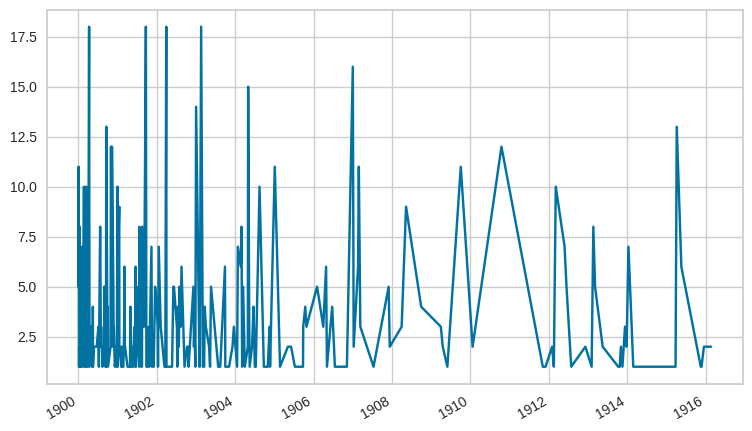

In [20]:
# We filter our dataframe specifically on the DOB column to make a decision regarding date ambiguity.
def filterDOB(dataframe):
    """
    Filters dataframe by DOB column

    Args:
        dataframe (DataFrame): Source dataset.

    Returns:
        DataFrame: A pandas DataFrame already modified.

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    return dataframe["CustomerDOB"].apply(lambda x: x if x.year < 1917 else 0)

df_filtered = filterDOB(df)


# Amortizing and removing values ​​greater than 1917 represented as 0
counts = df_filtered.value_counts().drop(0)
# Plot the amortized
counts.plot()
plt.show()
del df_filtered

<h3><b>Calculate customer age :</b></h3>
<b>CustomerDOB:</b> is the birth date of the customer 
<br>
<b>TransactionDate:</b> is the date of transaction that customer is done
<br>
The age calculation is done by <b>subtracting</b> the TransactionDate from the CustomerDOB.

In [21]:
# Getting the customer age at transaction moment and adding a new column in our dataframe
def getCustomerAge(dataframe):
    """
    Gets the customer age at transaction moment

    Args:
        dataframe (DataFrame): Source dataset.

    Returns:
        DataFrame: A pandas DataFrame already modified.

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    df['CustomerAge'] = (df['TransactionDate'] - df['CustomerDOB'])/np.timedelta64(1, 'Y')
    df['CustomerAge'] = df['CustomerAge'].astype(int)
    # Checking range of CustomerAge variable
    print("min: " + str(df['CustomerAge'].min()) + " max: " + str(df['CustomerAge'].max()))

getCustomerAge(df)

min: 16 max: 116


Once this is obtained, we have that the minimum age is equal to 16 years and the maximum age is equal to 116 years, it should be noted that the ages over 100 are a minimum percentage.

We obtain the percentage between customers who are women and men.

In [22]:
# Getting distinct values from CustGender variable
df.CustGender.value_counts()

M    712454
F    272868
Name: CustGender, dtype: int64

<h5> Visualize the distribution of the numeric data and detect posible outliers. Boxplots show the median, quartiles, and extreme values ​​of the data, and points that are above or below the extreme values ​​are considered outliers.</h5>

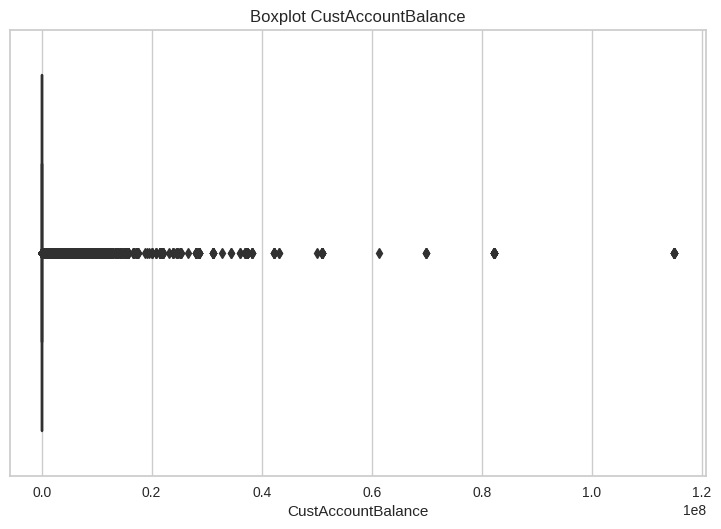

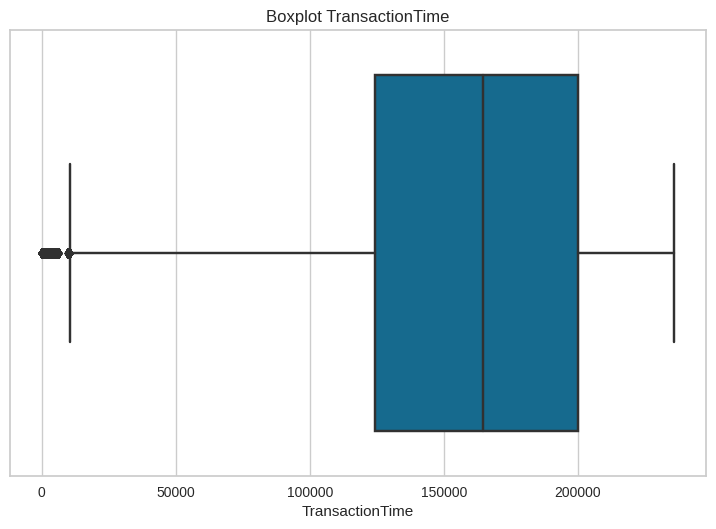

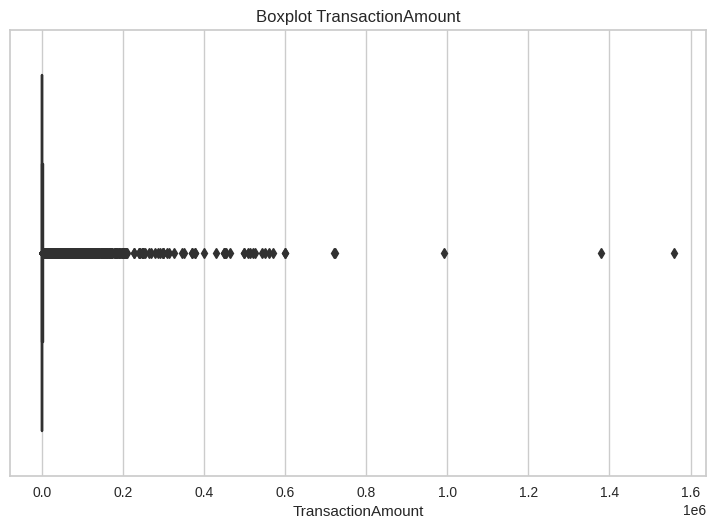

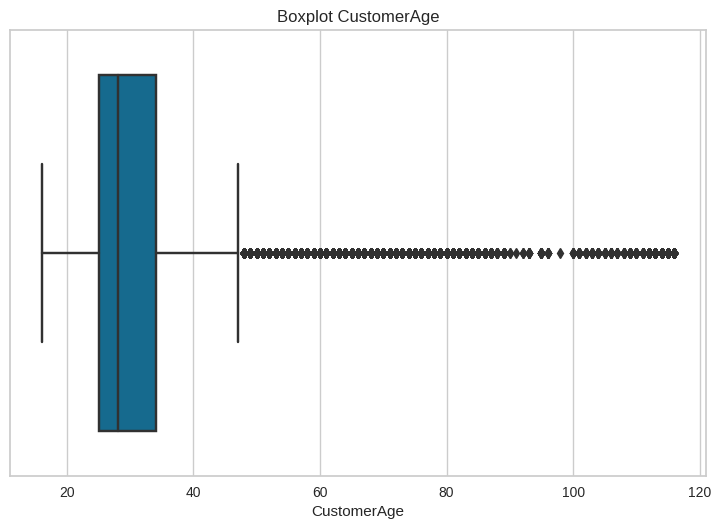

In [23]:
def outliers(dataframe):
    """
    Calculates the outliers for each numeric column in dataframe

    Args:
        dataframe (DataFrame): Source dataset.

    Returns:
        DataFrame: A pandas DataFrame already modified.

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    num_col = df.select_dtypes(include=np.number)
    cat_col = df.select_dtypes(exclude=np.number)

    for i in num_col.columns:
        sns.boxplot(x=num_col[i])
        plt.title("Boxplot " + i)
        plt.show()

outliers(df)

<h3 style="font-family:Sans-Serif; font-weight:bold">RFM Metrics:</h3>
<ul>
<li><b>Recency: </b>The freshness of customer activity e.g. time since last activity</li>
<li><b>Frequency: </b>The requency of customer transactions e.g. the totla number of recorded transactions</li>
<li><b>Monetary: </b>The willingness to spend e.g. the thoal transaction value</li>
</ul>

<p>Those two articles will help you to understand this topic:</p>
<a href="https://connectif.ai/en/what-are-rfm-scores-and-how-to-calculate-them/">What Are RFM Scores and How To Calculate Them</a>
<br>
<a href="https://www.datacamp.com/tutorial/introduction-customer-segmentation-python">Introduction to Customer Segmentation in Python</a>

We prepare some columns to make the RFM table

In [24]:
df['TransactionDate1']=df['TransactionDate'] # ==> to calculate the minimum (first transaction)
df['TransactionDate2']=df['TransactionDate'] # ==> to calculate the maximum (last transaction)

This code is used to create a RFM (Recency, Frequency, Monetary) table.
The data is grouped by CustomerID using the groupby method and then the agg function is used to calculate different metrics for each customer.

The metrics that are calculated are as follows:
<ul>
<li><b>TransactionID:</b> number of transactions performed by the customer.</li>
<li><b>CustGender:</b> customer's gender (taken from the first transaction recorded for the customer).</li>
<li><b>CustLocation:</b> location of the customer (also taken from the first transaction recorded for the customer).</li>
<li><b>CustAccountBalance:</b> average balance of the customer's account.</li>
<li><b>TransactionTime:</b> average time of transactions performed by the customer.</li>
<li><b>TransactionAmount:</b> average amount of transactions made by the customer.</li>
<li><b>CustomerAge:</b> median age of the client.</li>
<li><b>TransactionDate2:</b> most recent date on which the customer made a transaction.</li>
<li><b>TransactionDate1:</b> oldest date on which the customer made a transaction.</li>
<li><b>TransactionDate:</b> median date on which the customer made a transaction.</li>
</ul>

In [25]:
#Creating MRF Table Strategy

def MRFTable(df):   
    """
    Creates a MRF Table from a dataframe

    Args:
        dataframe (DataFrame): Source dataset.

    Returns:
        DataFrame: A pandas DataFrame already modified.

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    
    RFM_df = df.groupby("CustomerID").agg({
                                            "TransactionID" : "count",
                                            "CustGender" : "first",
                                            "CustLocation":"first",
                                            "CustAccountBalance"  : "mean",
                                            "TransactionTime": "mean",
                                            "TransactionAmount" : "mean",
                                            "CustomerAge" : "median",
                                            "TransactionDate2":"max",
                                            "TransactionDate1":"min",
                                            "TransactionDate":"median"
                            })

    RFM_df.reset_index()
    return RFM_df
    

RFM_df = MRFTable(df)
RFM_df.head()

,TransactionID,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount,CustomerAge,TransactionDate2,TransactionDate1,TransactionDate
CustomerID,,,,,,,,,,
C1010011,2,F,NOIDA,76340.635,67521.0,2553.0,28.5,2016-09-26,2016-08-09,2016-09-02
C1010012,1,M,MUMBAI,24204.490,204409.0,1499.0,22.0,2016-08-14,2016-08-14,2016-08-14
C1010014,2,F,MUMBAI,100112.950,187378.0,727.5,27.5,2016-08-07,2016-08-01,2016-08-04
C1010018,1,F,CHAMPARAN,496.180,170254.0,30.0,26.0,2016-09-15,2016-09-15,2016-09-15
C1010024,1,M,KOLKATA,87058.650,141103.0,5000.0,51.0,2016-08-18,2016-08-18,2016-08-18


Now we calculate the number of records we have left after grouping by CustomerID

In [26]:
# After Grouping by CustomerID
RFM_df.shape

(839081, 10)

<h4><b>Frequency</b></h4>
<p>As we count the TransactionID column, we can replace the name of this column by Frequency, because this is the number of times a customer has made a transaction.</p>

In [27]:
# Renaming specific column adapting to problem goal and replacing with inplace property of function
RFM_df.rename(columns={"TransactionID":"Frequency"},inplace=True)

<h4><b>Recency</b></h4>
<p>The recency is the number of days since the last purchase or order so we will create a new column of TransactionDate to subtract the last transaction from the first transaction</p>

In [28]:
# Getting Recency that is by definition: number of days since the last purchase or order
RFM_df['Recency']=RFM_df['TransactionDate2']-RFM_df['TransactionDate1']
# Conversion from timedelta64[ns] to string representtion in days of weeks of Recency variable
RFM_df['Recency']=RFM_df['Recency'].astype(str)

We apply a lambda function to adjust the format of our output in the Recency variable

In [29]:
def formatOutputInRecency(RFM_df):
    
    """
    Formats the output of Recency column

    Args:
        dataframe (DataFrame): Source dataset.

    Returns:
        DataFrame: A pandas DataFrame already modified.

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    # Using re library for apply an regular expresion in each value of Recency column for extract the number of days in this string representation. 
    RFM_df['Recency']=RFM_df['Recency'].apply(lambda x :re.search('\d+',x).group())
    # Conversion from string '18' to int representtion for folloeing operations
    RFM_df['Recency']=RFM_df['Recency'].astype(int)

formatOutputInRecency(RFM_df)

<p> <b>Appreciation:</b> Days mean that a customer has done transaction recently one time by logic so I will convert 0 to 1 </p>

In [30]:
# Transformation of 0 days base on business meaning
RFM_df['Recency'] = RFM_df['Recency'].apply(lambda x: 1 if x == 0 else x)

The TransactionDate1 and TransactionDate2 columns have already fulfilled their objectives, which is to calculate the Recency, we can eliminate these columns.

In [31]:
# Columns that were only needed for the calculation we eliminated
RFM_df.drop(columns=["TransactionDate1","TransactionDate2"],inplace=True)

Now, let's see if our DataSet once cleaned contains atypical data

In [32]:
# To calculate the otliers for each feature
def outliersWhenCleaned():
    
    """
    Calculates the outliers for each feature once the data is cleaned

    Args:
        none
    
    Returns:
       print: A print with the outliers for each feature

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """

    lower_list=[]
    upper_list=[]
    num_list=[]
    perc_list=[]
    cols=['Frequency', 'CustAccountBalance','TransactionAmount', 'CustomerAge', 'Recency']
    for i in cols:
        Q1 = RFM_df[i].quantile(0.25)
        Q3 = RFM_df[i].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        # Calculate number of outliers
        num=RFM_df[(RFM_df[i] < lower) | (RFM_df[i] > upper)].shape[0]
        # Calculate percentage of outliers
        perc = (num / RFM_df.shape[0]) * 100
        lower_list.append(lower)
        upper_list.append(upper)
        num_list.append(num)
        perc_list.append(round(perc,2))

        
    dic={'lower': lower_list, 'upper': upper_list, 'outliers': num_list, 'Perc%':perc_list }
    outliers_df=pd.DataFrame(dic,index=['Frequency', 'CustAccountBalance','TransactionAmount', 'CustomerAge', 'Recency'])
    outliers_df

outliersWhenCleaned()

<h3 style="font-family:Sans-Serif; font-weight:bold">Observations:</h3>
<p>We will not remove outliers for the following two reasons: First, in boxplots those values ​​can be outliers because they represent points that are above or below extreme values. However, these were not measurement errors and are both true and significant, given that while customers 100+ do not represent a key demographic for most banks. Secoind it is important that banks are aware of the specific needs and challenges that these clients may face, and that they adapt their strategies accordingly.</p>

Now, let's go to see our RFM Table

In [33]:
RFM_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount,CustomerAge,TransactionDate,Recency
CustomerID,,,,,,,,,
C1010011,2,F,NOIDA,76340.635,67521.0,2553.0,28.5,2016-09-02,48
C1010012,1,M,MUMBAI,24204.490,204409.0,1499.0,22.0,2016-08-14,1
C1010014,2,F,MUMBAI,100112.950,187378.0,727.5,27.5,2016-08-04,6
C1010018,1,F,CHAMPARAN,496.180,170254.0,30.0,26.0,2016-09-15,1
C1010024,1,M,KOLKATA,87058.650,141103.0,5000.0,51.0,2016-08-18,1


We describe each of the columns with different factors

In [34]:
RFM_df.describe()

,Frequency,CustAccountBalance,TransactionTime,TransactionAmount,CustomerAge,Recency
count,839081.000000,8.390810e+05,839081.000000,8.390810e+05,839081.000000,839081.000000
mean,1.174287,1.058545e+05,157446.381829,1.453624e+03,30.755438,3.666118
std,0.435129,7.862524e+05,49194.229430,6.045200e+03,8.706026,8.061373
min,1.000000,0.000000e+00,0.000000,0.000000e+00,16.000000,1.000000
25%,1.000000,5.366190e+03,125604.000000,1.800000e+02,25.000000,1.000000
50%,1.000000,1.768220e+04,163936.000000,4.750000e+02,29.000000,1.000000
75%,1.000000,5.723652e+04,194953.000000,1.175730e+03,34.000000,1.000000
max,6.000000,1.150355e+08,235959.000000,1.560035e+06,116.000000,81.000000


It creates a correlation matrix between the different features in the RFM table (RFM_df), and then plots this matrix as a heat map using it. The correlation matrix is a square matrix that shows how the different features are related to each other.

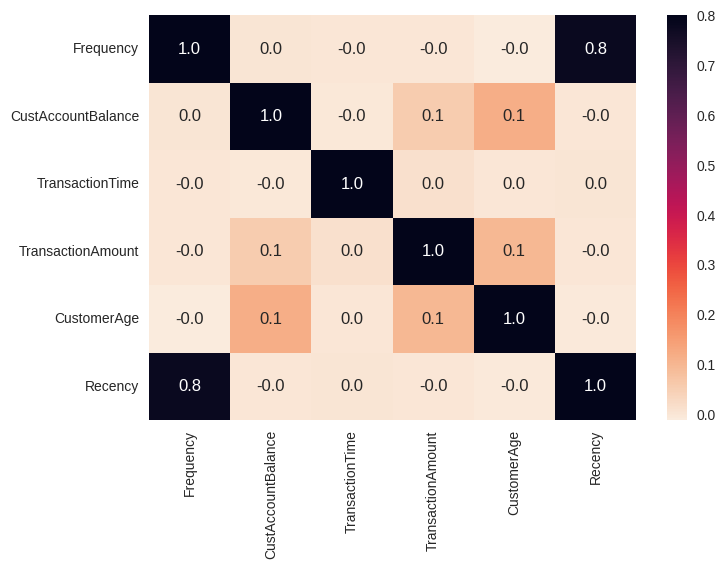

In [35]:
# correlation between features
def correlation():
    
    """
    Calculates the correlation between features

    Args:
        none

    Returns:
        heatmap: A heatmap with the correlation between features

    Raises:
        TypeError: If the dataframe is not a DataFrame. 
    """

    plt.figure(figsize=(7,5))
    correlation=RFM_df.corr(numeric_only=True)
    sns.heatmap(correlation,vmin=None,
        vmax=0.8,
        cmap='rocket_r',
        annot=True,
        fmt='.1f',
        linecolor='white',
        cbar=True);

correlation()

We obtain the frequency bar chart, this chart shows the distribution of the variable Frequency, it is worth noting that the frequency is the number of times a customer has made transactions in the period from August to October.

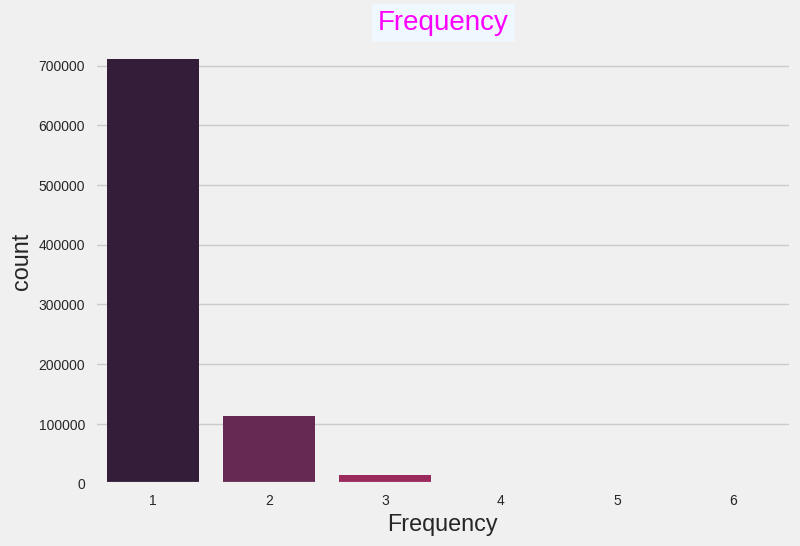

In [36]:
def distributionFrequency():
    
    """
    Plots the distribution of Frequency variable

    Args:
        none

    Returns:
        chart: A chart with the distribution of Frequency variable

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    plt.style.use("fivethirtyeight")
    chart=sns.countplot(x='Frequency',data=RFM_df,palette='rocket', order = RFM_df['Frequency'].value_counts().index)
    plt.title("Frequency",
            fontsize='20',
            backgroundcolor='AliceBlue',
            color='magenta');

distributionFrequency()

We obtain the age distribution of the clients and also the percentage of women and men in the records we have.

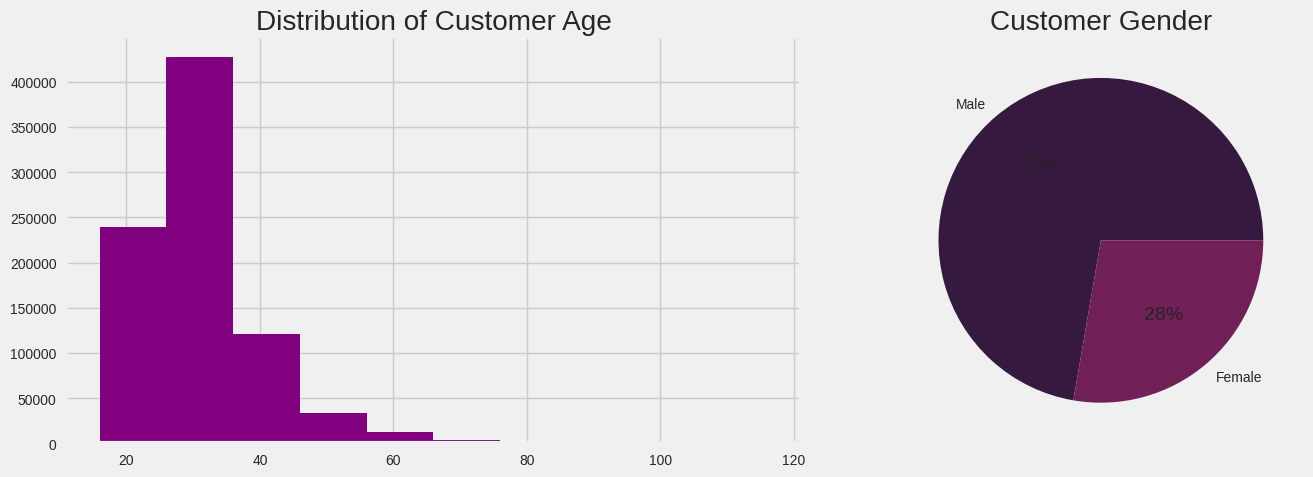

In [37]:
def graphAgeAndGender():
    
    """
    Shows a graph with the distribution of the age and a pie graph of the gender in the dataset

    Args:
        none

    Returns:
        histogram: A histogram with the distribution of the age
        pie: percentage of women and men

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """

    plt.style.use("fivethirtyeight")
    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
    palette_color = sns.color_palette('rocket')
    ax[0].hist(x=RFM_df['CustomerAge'],color='purple')
    ax[0].set_title("Distribution of Customer Age")
    ax[1].pie(RFM_df['CustGender'].value_counts(),autopct='%1.f%%',colors=palette_color,labels=['Male','Female'])
    ax[1].set_title("Customer Gender")
    plt.tight_layout();

graphAgeAndGender()

In this graph we obtain the number of times a transaction was made in different areas of the country, only the top 20 locations with the most transactions made will be shown.

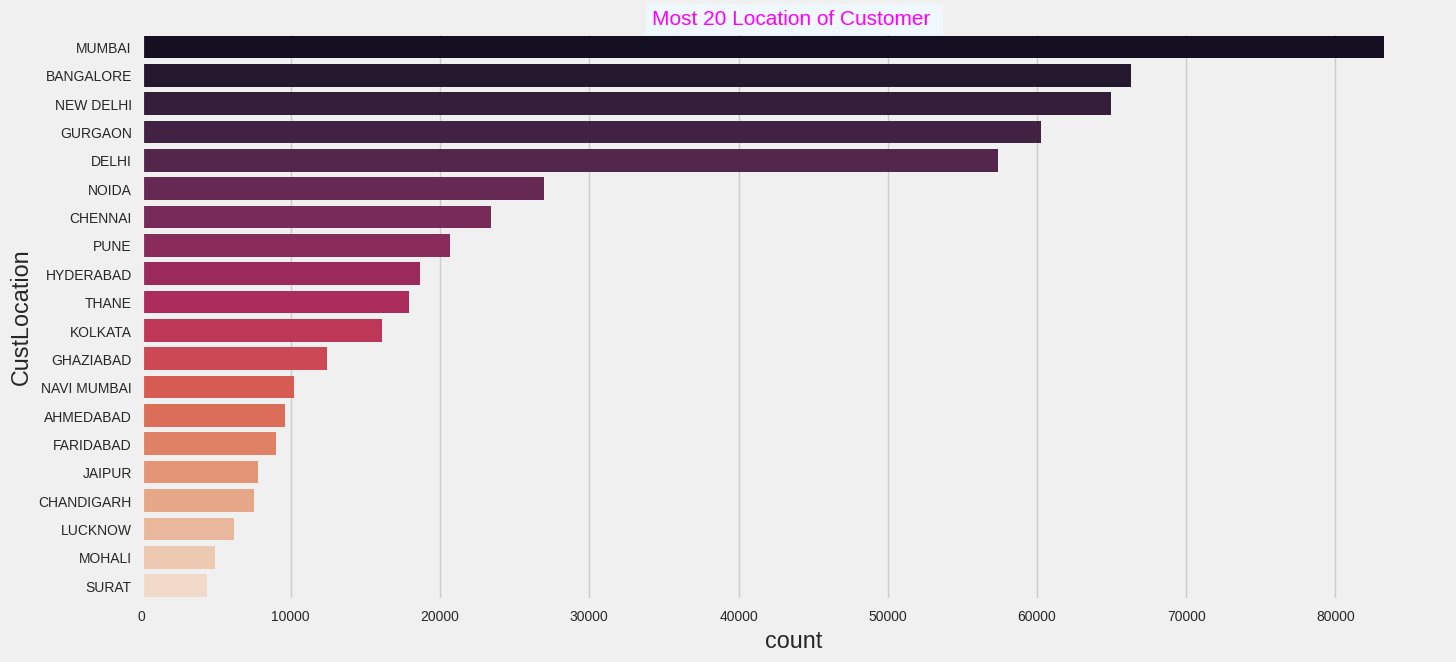

In [38]:
def graphLocation():
    
    """
    Shows a graph with the distribution of the location in the dataset

    Args:
        none

    Returns:
        chart: A chart with the distribution of the location

    Raises:
        TypeError: If the dataframe is not a DataFrame.

    """
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(15,7))
    chart=sns.countplot(y='CustLocation',data=RFM_df,palette='rocket', order = RFM_df['CustLocation'].value_counts()[:20].index)
    plt.title("Most 20 Location of Customer ",
            fontsize='15',
            backgroundcolor='AliceBlue',
            color='magenta');

graphLocation()

We generate the scatter plot of the data referring to the variable Frequency.

In [39]:
def scatterOFData():
    
    """
    Shows a scatter plot of the data

    Args:
        none

    Returns:
        chart: A chart with the scatter plot of the data

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    plt.style.use("fivethirtyeight")
    sns.pairplot(RFM_df,hue='Frequency')

#scatterOFData()

This code generates a scatter plot. The data used comes from the RFM_df dataframe and is represented on the X axis (horizontal) the transaction amounts (TransactionAmount) and on the Y axis (vertical) the customer's account balance (CustAccountBalance). We add a third dimension to the graph which is Frequency and a fourth one with Recency.

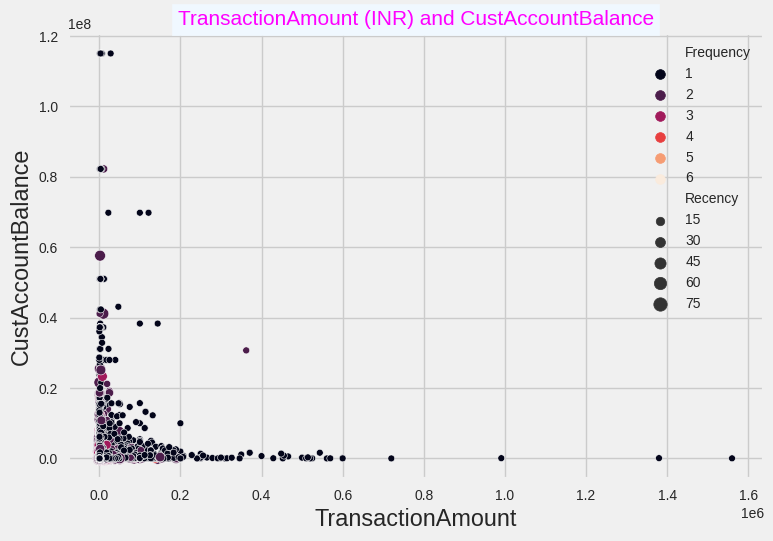

In [40]:
def graphTransactionAmountAndCustAccountBalance():
    
    """
    Shows a scatter plot of the TransactionAmount and CustAccountBalance

    Args:
        none

    Returns:
        chart: A chart with the scatter plot of the TransactionAmount and CustAccountBalance

    Raises:
        TypeError: If the dataframe is not a DataFrame.
        
    """

    plt.style.use("fivethirtyeight")
    sns.scatterplot(x='TransactionAmount',y='CustAccountBalance',data=RFM_df,palette='rocket',hue='Frequency',size='Recency' )
    plt.legend(loc = "upper right")
    plt.title("TransactionAmount (INR) and CustAccountBalance",
            fontsize='15',
            backgroundcolor='AliceBlue',
            color='magenta');

graphTransactionAmountAndCustAccountBalance()

We calculate the farthest distance between two completed transactions

In [41]:
# difference between maximum and minimum date
RFM_df['TransactionDate'].max()-RFM_df['TransactionDate'].min()

Timedelta('81 days 00:00:00')

We group the transactions according to the month in which they were made and obtain the average for each table.

In [42]:
RFM_df['TransactionMonth'] = RFM_df["TransactionDate"].dt.month
RFM_df['TransactionMonthName'] = RFM_df["TransactionDate"].dt.month_name()
RFM_df['TransactionDay'] = RFM_df["TransactionDate"].dt.day
RFM_df['TransactionDayName'] = RFM_df["TransactionDate"].dt.day_name()
RFM_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount,CustomerAge,TransactionDate,Recency,TransactionMonth,TransactionMonthName,TransactionDay,TransactionDayName
CustomerID,,,,,,,,,,,,,
C1010011,2,F,NOIDA,76340.635,67521.0,2553.0,28.5,2016-09-02,48,9,September,2,Friday
C1010012,1,M,MUMBAI,24204.490,204409.0,1499.0,22.0,2016-08-14,1,8,August,14,Sunday
C1010014,2,F,MUMBAI,100112.950,187378.0,727.5,27.5,2016-08-04,6,8,August,4,Thursday
C1010018,1,F,CHAMPARAN,496.180,170254.0,30.0,26.0,2016-09-15,1,9,September,15,Thursday
C1010024,1,M,KOLKATA,87058.650,141103.0,5000.0,51.0,2016-08-18,1,8,August,18,Thursday


Female customers perform higher transactions than their male counterparts in almost every week day.

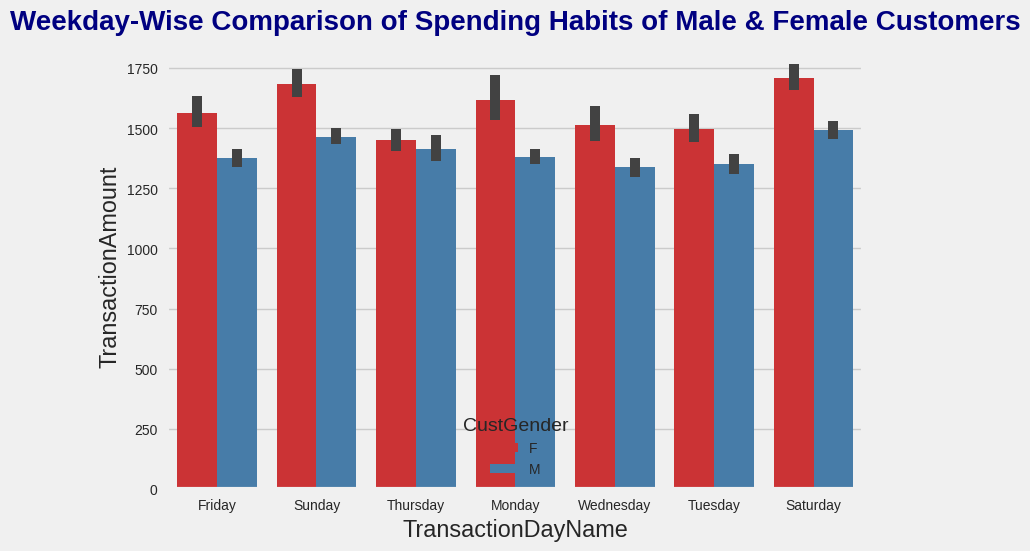

In [43]:
sns.barplot(data=RFM_df,x='TransactionDayName',y='TransactionAmount',palette='Set1',hue='CustGender')
plt.title('Weekday-Wise Comparison of Spending Habits of Male & Female Customers',fontsize=20,fontweight='bold',color='navy',pad=10);

Female customers perform greater transactions. Therefore, the bank must provide more special offers and incentives to female customers as they are likely to be substantially active in making larger transactions almost throughout the entire year.

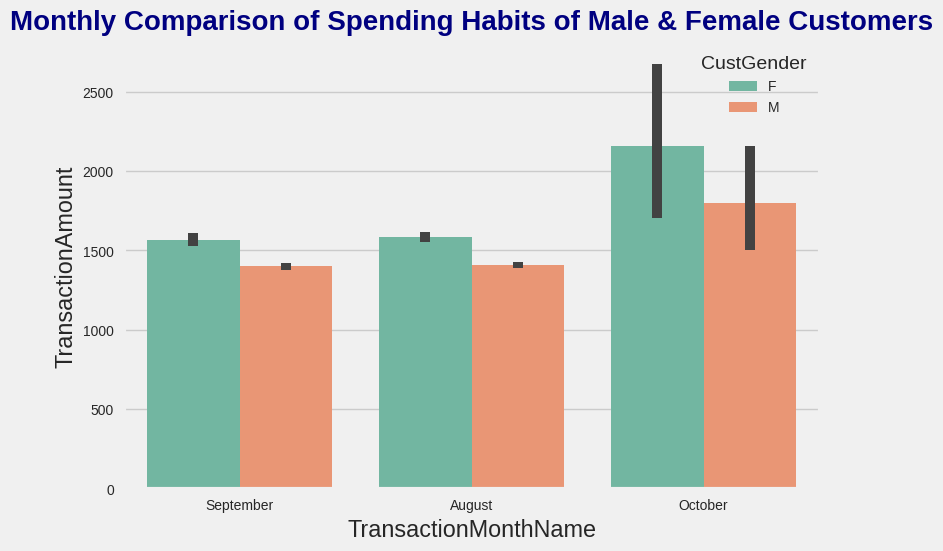

In [44]:
sns.barplot(data=RFM_df,x='TransactionMonthName',y='TransactionAmount',palette='Set2',hue='CustGender')
plt.title('Monthly Comparison of Spending Habits of Male & Female Customers',fontsize=20,fontweight='bold',color='navy',pad=10);

In [45]:
def groupTransaccionsByMonth(RFM_df):
    
    """
    Groups the transactions by month and calculates the mean of each feature

    Args:
        none

    Returns:
        groupbby_month: A dataframe with the mean of each feature base on month

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    RFM_df = RFM_df.sort_values(by='TransactionDate')
    groupbby_month = RFM_df.groupby([pd.Grouper(key='TransactionDate', freq='M')])[['Frequency', 'TransactionAmount', 'CustAccountBalance', 'TransactionTime', 'CustomerAge']].mean()
    print(groupbby_month.shape)
    return groupbby_month

groupbby_month = groupTransaccionsByMonth(RFM_df)
groupbby_month.head()

(3, 5)


,Frequency,TransactionAmount,CustAccountBalance,TransactionTime,CustomerAge
TransactionDate,,,,,
2016-08-31,1.196796,1455.968945,106177.136987,156767.237318,30.780328
2016-09-30,1.135252,1445.607858,105375.580700,158413.057073,30.710065
2016-10-31,1.056486,1904.367370,94726.805639,185756.771718,30.884106


We made line graphs of the information we obtained previously.

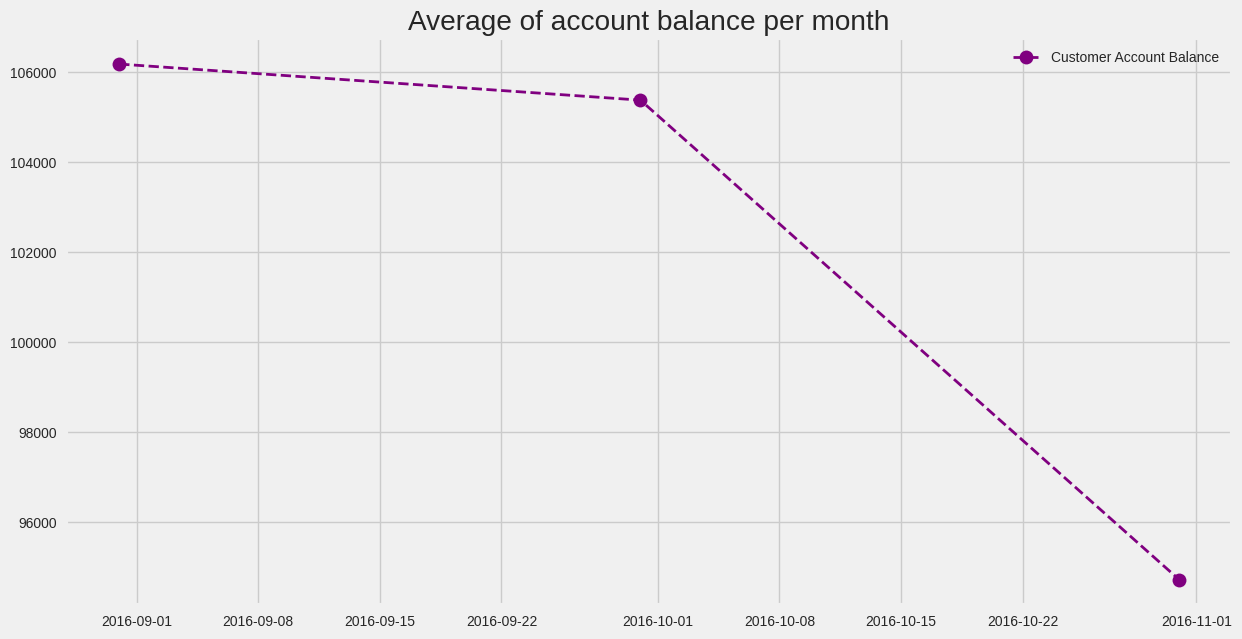

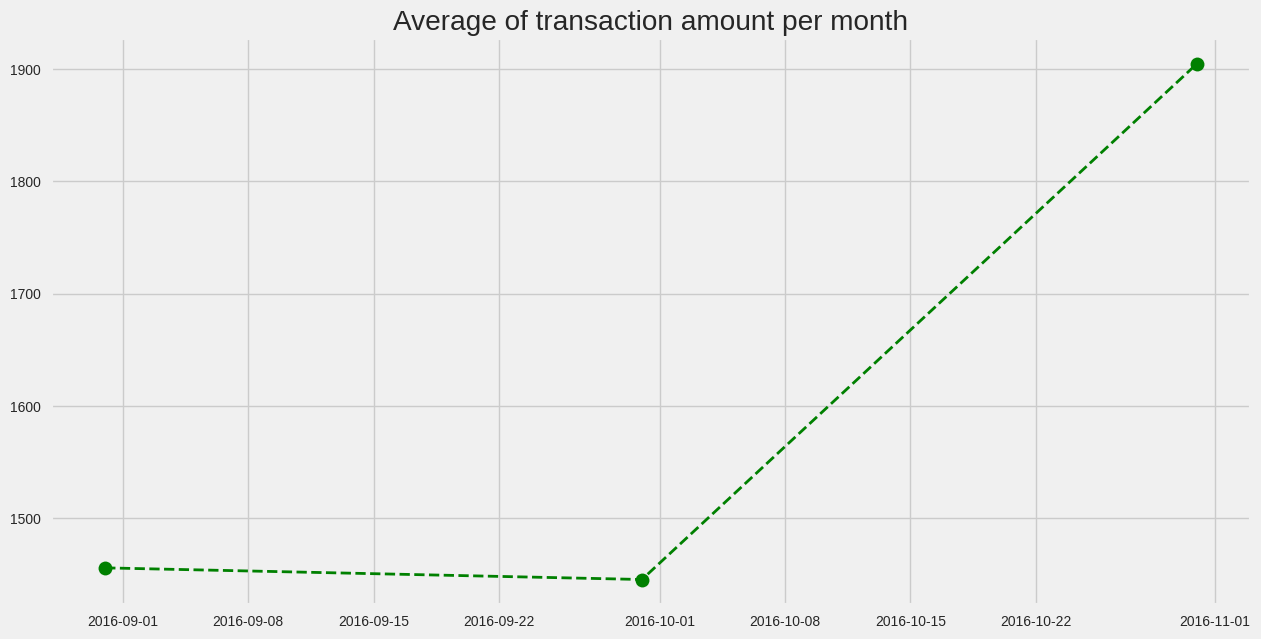

In [46]:
def grphLineBalanceAndTransactionAmount():
    
    """
    Shows a line graph of the average of account balance and transaction amount per month

    Args:
        none

    Returns:
        chart: A chart with the line graph of the average of account balance and transaction amount per month

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    plt.figure(figsize=(13.4,7))
    plt.title("Average of account balance per month")
    plt.plot(groupbby_month.index,groupbby_month['CustAccountBalance'],color='purple',marker='o',label='Customer Account Balance', linestyle='dashed', linewidth=2, markersize=10)
    plt.legend();

    plt.figure(figsize=(13.8,7))
    plt.title("Average of transaction amount per month")
    plt.plot(groupbby_month.index,groupbby_month['TransactionAmount'],color='green',marker='o',label='Transaction Amount', linestyle='dashed', linewidth=2, markersize=10)

grphLineBalanceAndTransactionAmount()

## 5. Feature Engineering

In [ ]:
RFM_df=RFM_df.reset_index(drop=True)

In [ ]:
def replaceGenderforInt():
    
    """
    Replace de gender data to -1 if is women and 1 if is men

    Args:
        none

    Returns:
        none

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    RFM_df.CustGender.replace(['F','M'],[-1,1],inplace=True)
    RFM_df.CustGender = RFM_df.CustGender.astype(np.int64)

replaceGenderforInt()

We decided to drop the next features, as they are not important to the problem.

In [ ]:
RFM_df.drop(['TransactionDate'], axis=1, inplace=True) # Porque creamos 3 variable basadas en la fecha, Dia, Mes, Nombre dia
RFM_df.drop(['Recency'], axis=1, inplace=True) # Correlación con variable frecuuencia

In [ ]:
def dataToEncoder(RFM_df):
      
    """
      Apply the label encoder to the data, transform variable type objects or string to int

      Args:
        The Dataset

      Returns:
        none

      Raises:
        TypeError: If the dataframe is not a DataFrame.
    """
    encoder = LabelEncoder()
    RFM_df.CustLocation = encoder.fit_transform(RFM_df.CustLocation)
    RFM_df.TransactionMonthName = encoder.fit_transform(RFM_df.TransactionMonthName)
    RFM_df.TransactionDayName = encoder.fit_transform(RFM_df.TransactionDayName)
    # Custom Cast
    RFM_df.CustLocation = RFM_df.CustLocation.astype(np.int64)
    RFM_df.TransactionMonthName = RFM_df.TransactionMonthName.astype(np.int64)
    RFM_df.TransactionDayName = RFM_df.TransactionDayName.astype(np.int64)
    return RFM_df

RFM_df = dataToEncoder(RFM_df)

Tecnicas de reducción de dimencionalidad: Analisis de Componentes principales

El gráfico muestra la suma acumulativa de la varianza explicada por cada componente principal (PC) en un Análisis de Componentes Principales (PCA). La varianza explicada indica la cantidad de información que se conserva después de reducir la dimensionalidad de los datos. En el eje x del gráfico, se muestra el número de componentes principales y en el eje y se muestra la varianza explicada acumulativa. La línea azul muestra cómo se acumula la varianza explicada a medida que se agregan más componentes principales. Por lo tanto, el gráfico permite evaluar cuántos componentes principales son necesarios para conservar la mayor cantidad de información posible en los datos.  En general, se busca encontrar un equilibrio entre la cantidad de componentes principales utilizados y la cantidad de varianza explicada.

                 feature    importance
0              Frequency  9.960355e-01
1             CustGender  3.899204e-03
2           CustLocation  5.869700e-05
3     CustAccountBalance  6.552220e-06
4        TransactionTime  1.216498e-10
5      TransactionAmount  1.175417e-10
6            CustomerAge  6.117558e-12
7       TransactionMonth  1.612191e-12
8   TransactionMonthName  1.287304e-12
9         TransactionDay  3.009819e-13
10    TransactionDayName  8.716306e-15


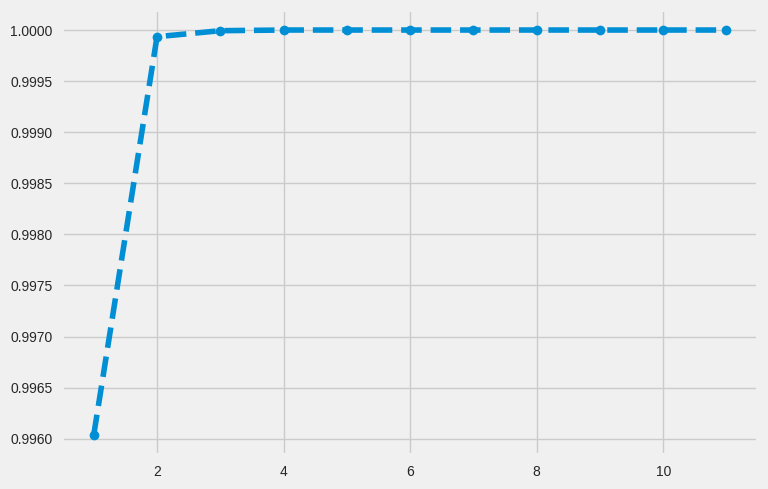

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def pca_analysis(df):

    """
    We are going to do the method of PCA to find the best features

    Args:
        The Dataset

    Returns:
        none

    Raises:
        TypeError: If the dataframe is not a DataFrame.
    """

    pca = PCA()
    pca.fit(df)
    plt.plot(range(1,len(pca.explained_variance_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')

    components = pca.components_
    variance_ratio = pca.explained_variance_ratio_
    features_importance = pd.DataFrame({"feature": df.columns, "importance": variance_ratio})
    features_importance = features_importance.sort_values("importance", ascending=False)
    return features_importance

pipeline = Pipeline([
    ('pca', FunctionTransformer(pca_analysis))
])

features_importance = pipeline.fit_transform(RFM_df)
print(features_importance)

We only selected the best features from the dataset, so we discarded those of lesser importance.

In [ ]:
RFM_df.drop(['TransactionMonth', 'TransactionMonthName', 'TransactionDay', 'TransactionDayName'], axis=1, inplace=True)

Now, we are going to apply a scaling method, the goal is to get a mean equal to 0 and a standard deviation equal to 1.

In [ ]:
def scale_data(df):
    """
    Scale the data using StandardScaler.

    Args:
        df (pd.DataFrame): The input data to be scaled.

    Returns:
        pd.DataFrame: The scaled data.

    """
    column_names = df.columns
    scaler = StandardScaler()
    scaler.fit(df)
    df = pd.DataFrame(scaler.transform(df), columns=column_names)
    return df

pipeline = Pipeline([
    ('scaler', FunctionTransformer(scale_data)),
])

RFM_df = pipeline.fit_transform(RFM_df)
RFM_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount,CustomerAge
0,1.897629,-1.615225,0.746619,-0.037537,-1.827967,0.181860,-0.259066
1,-0.400541,0.619109,0.493720,-0.103847,0.954637,0.007506,-1.005676
2,1.897629,-1.615225,0.493720,-0.007302,0.608438,-0.120116,-0.373929
3,-0.400541,-1.615225,-1.087143,-0.134001,0.260348,-0.235497,-0.546224
4,-0.400541,0.619109,0.071231,-0.023906,-0.332222,0.586644,2.325352


In [ ]:
RFM_df.CustAccountBalance.max()

146.174071799302

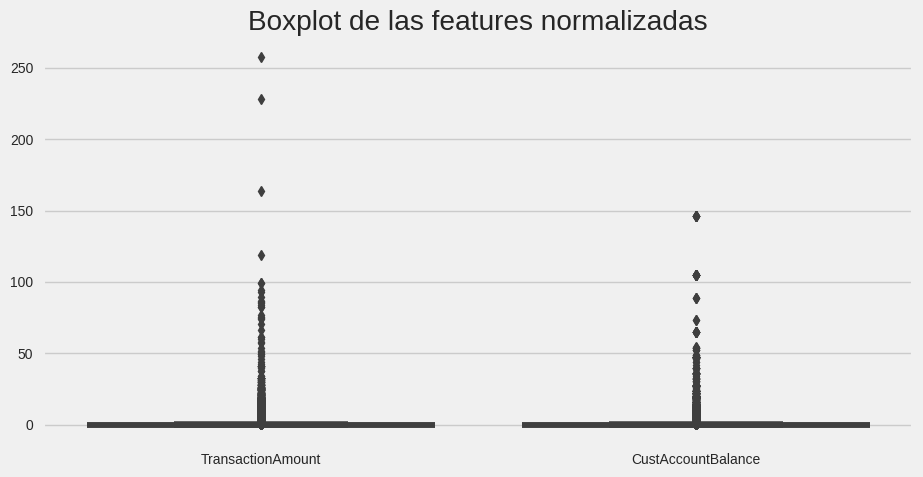

In [ ]:
def plot_boxplot(df, columns):
    """
    Crea un gráfico de boxplot para las columnas especificadas de un DataFrame normalizado.

    Args:
        df (pandas.DataFrame): El DataFrame a graficar.
        columns (list): Lista de nombres de columnas para graficar.

    Returns:
        None
    """
    df_norm = pd.DataFrame(df, columns=columns)
    fig, ax = plt.subplots(figsize=(10,5))
    sns.boxplot(data=df_norm, ax=ax, palette="Paired")
    plt.title("Boxplot de las features normalizadas")
    plt.show()

plot_boxplot(RFM_df, columns=['TransactionAmount', 'CustAccountBalance'])

In [ ]:
def encode_units(x):
    """
    Encode units to binary values.

    Args:
      x: input unit.

    Returns:
      int: 1 if x >= 1, 0 otherwise.
    """
    if x <= 0:
      return 0
    if x >= 1:
      return 1

In [ ]:
def get_frequent_itemsets(df):
    """
    Apply apriori algorithm on input DataFrame to obtain frequent itemsets.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: Dataframe with frequent itemsets and their support.

    """
    RFM_df_boolean = df.applymap(encode_units)
    frequent_itemsets = apriori(RFM_df_boolean.fillna(0), min_support=0.05, use_colnames=True)

    return frequent_itemsets

get_frequent_itemsets(RFM_df)

,support,itemsets
0,0.153616,(Frequency)
1,0.158243,(CustLocation)
2,0.144920,(TransactionTime)
3,0.123739,(CustomerAge)


Now we selected the best features to start to build and fit our models

In [ ]:
RFM_df_importance = RFM_df[["Frequency","CustLocation", "CustGender", "CustAccountBalance", "TransactionAmount", "CustomerAge"]]

## 6. Unsupervised learning modeling

### K-mean
The k-means clustering is a method of vector quantization, originally from signal processing, that

 1. The Elbow method 
Is a graphical representation of finding the optimal 'K' in a K-means cluster

 2. The Silhouette Coefficient
Is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1. 1: Means clusters are well apart from each other and clearly distinguished

 3. The Dendrogram 
Is a diagram that shows the hierarchical relationship between objects. It is most commonly created as an output from hierarchical clustering

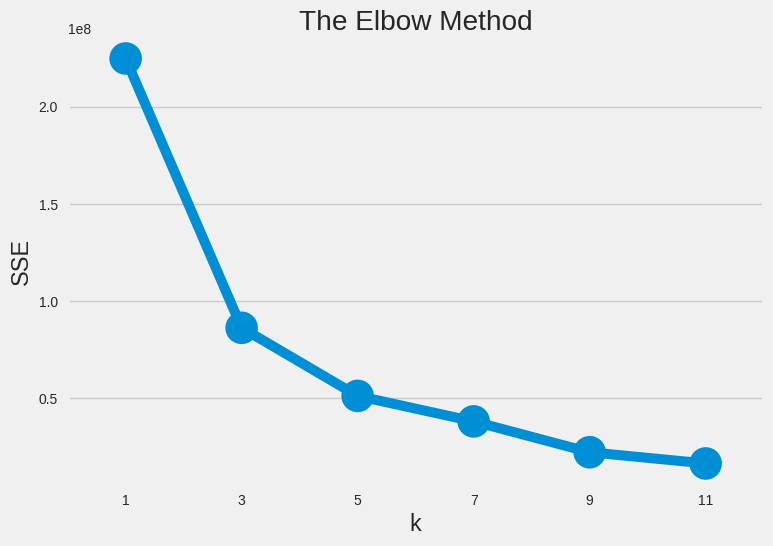

In [ ]:
def calculate_sse(data):
    """
    Calculates the sum of squared errors (SSE) for a range of k values (number of clusters)
    using the KMeans algorithm and plots the resulting SSE values.

    Args:
      data: A pandas DataFrame with the input data for KMeans clustering.

    Returns:
      A dictionary with the SSE values for each k value.
    """
    sse = {}
    for k in range(1, 12, 2):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(data)
        sse[k] = kmeans.inertia_
    plt.title("The Elbow Method")
    plt.xlabel('k')
    plt.ylabel('SSE')
    sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
    plt.show()

calculate_sse(RFM_df_importance)

<h4>Busqueda de hiperparametros K</h4>
El objetivo es encontrar un punto donde la adición de un cluster adicional ya no contribuya significativamente a la variación explicada

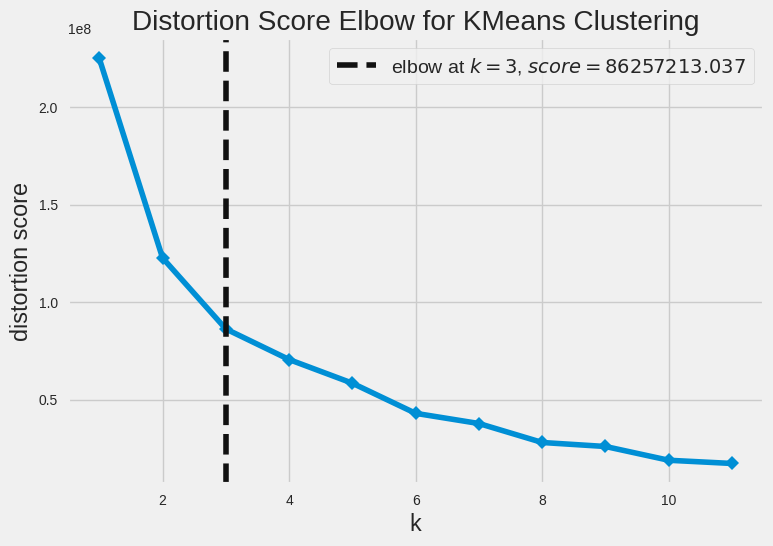

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
def elbowFindValue(RFM_df_importance):
    """
    This function fits a KMeans model and generates an elbow plot to help identify the optimal number of clusters.
    The function returns the optimal number of clusters identified by the elbow plot.  
  
    Args:
      df (pandas.DataFrame): DataFrame with the data to fit the model to.
    
    Returns:
      none
    """
    model = KMeans(init = 'random',n_init='auto', random_state = 42)
    visualizer = KElbowVisualizer(model, k=(1,12), timings=False)
    visualizer2 = KElbowVisualizer(model, k=(1,12), timings=False)
    visualizer.fit(RFM_df_importance)
    visualizer.show()

elbowFindValue(RFM_df_importance)

In [ ]:
pipeline = Pipeline([
    ('kmeans', KMeans(init='random', n_init='auto', random_state=42)),
    ('grid_search', GridSearchCV(KMeans(random_state=42, n_init='auto'), param_grid={'n_clusters': range(3,6,2)}, cv=5)),
])

pipeline.fit(RFM_df_importance)

print("Mejor número de clusters: ", pipeline['grid_search'].best_params_['n_clusters'])
print("Mejor score: ", pipeline['grid_search'].best_score_)

Mejor número de clusters:  5
Mejor score:  -10684588.976592684


#### Primer modelo con K = 3


Like, we got two possible values to K, we are going to try with the first value, in this case the value will be 3

In [ ]:
model1 = KMeans(n_clusters=3, random_state=42, n_init='auto')
model1.fit(RFM_df_importance)

KMeans(n_clusters=3, n_init='auto', random_state=42)

In [ ]:
def groupByCluster3(RFM_df_importance, model1):
    """
    This function generates a summary of the clusters generated by a KMeans model.
    
    Args:
      df (pandas.DataFrame): DataFrame with the data used to generate the clusters.
      model1: model of the kmeans fit
    Returns:
      RFM_df_kmeans3: the new Dataset
    """
    RFM_df_kmeans3 = RFM_df_importance
    RFM_df_kmeans3["Cluster"] = model1.labels_
    RFM_df_kmeans3.groupby("Cluster").agg({
      "Frequency": "mean",
      "CustGender": "mean",
      "CustAccountBalance": "mean",
      "TransactionAmount": "mean",
      "CustomerAge" : "mean"
    }).round(2)

    return RFM_df_kmeans3
  
RFM_df_kmeans3 = groupByCluster3(RFM_df_importance, model1)

<ipython-input-64-e30aa4e1c3d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFM_df_kmeans3["Cluster"] = model1.labels_


,Frequency,CustGender,CustAccountBalance,TransactionAmount,CustomerAge
Cluster,,,,,
0,0.03,-0.28,1.23,1.08,0.29
1,0.00,-0.11,727.21,5.56,2.37
2,0.03,-0.21,114.77,3.25,1.65


We are going to do the scatter plot to view the relation between the CustAccountBalance and TransactionAmount

<Axes: xlabel='CustAccountBalance', ylabel='TransactionAmount'>

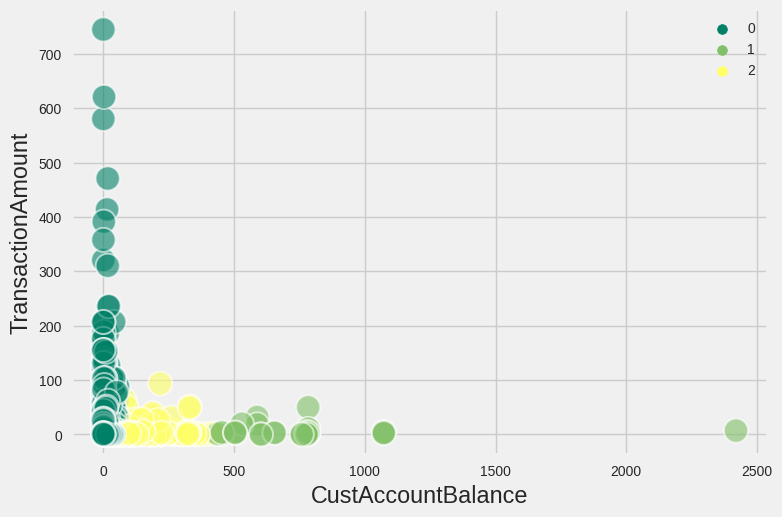

In [ ]:
sns.scatterplot(data=RFM_df_importance ,x='CustAccountBalance',y='TransactionAmount',hue=model1.labels_,s=300,alpha=0.6,palette='summer')

<ipython-input-66-c2633c6af93d>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
<ipython-input-66-c2633c6af93d>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


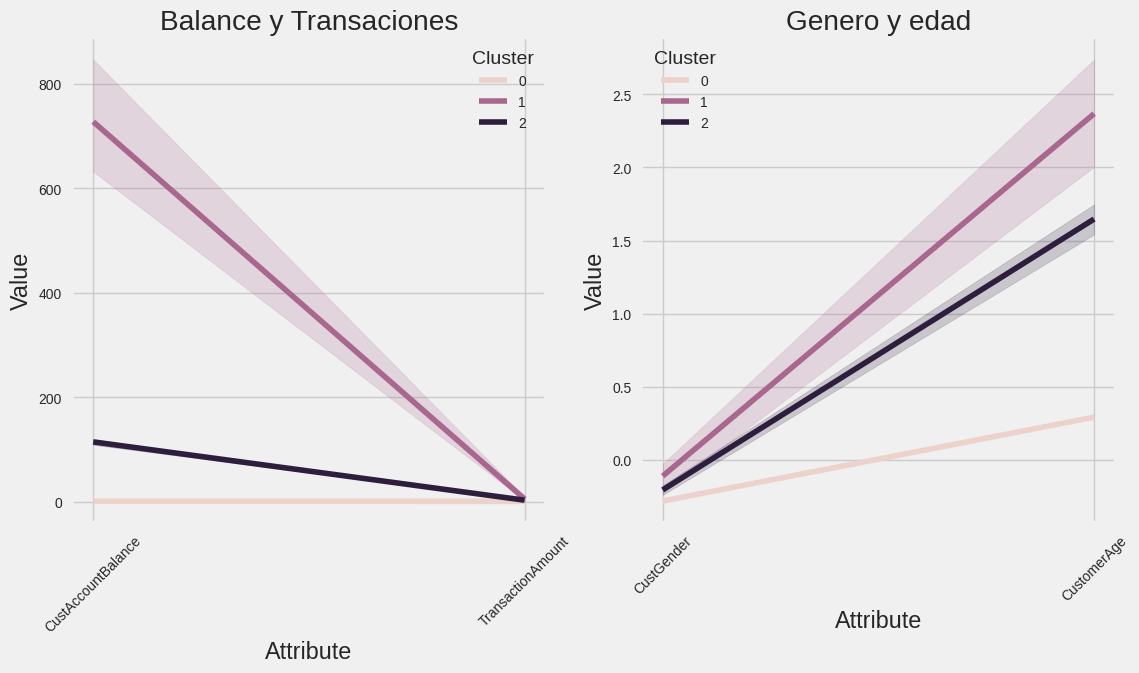

In [ ]:
def viewTheClustersKmeans3(RFM_df_kmeans3):
    """
    This function generate the plot with the clusters
    
    Args:
      df (pandas.DataFrame): DataFrame with the data used to generate the clusters.
    
    Returns:
      none
    """

    df_n = pd.DataFrame(RFM_df_kmeans3, columns=["Frequency", "CustGender", "CustLocation", "CustAccountBalance", "TransactionAmount", "CustomerAge"])

    df_n["ID"] = RFM_df_kmeans3.index
    df_n["Cluster"] = model1.labels_

    df_nor_melt = pd.melt(df_n.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=["CustAccountBalance", "TransactionAmount"],
                      var_name='Attribute',
                      value_name='Value')

    df_nor_melt2 = pd.melt(df_n.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=[ "CustGender", "CustomerAge"],
                      var_name='Attribute',
                      value_name='Value')

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_nor_melt, ax=ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_title('Balance y Transaciones')

    sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_nor_melt2, ax=ax2)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    ax2.set_title('Genero y edad')

    plt.show()

viewTheClustersKmeans3(RFM_df_kmeans3)

El algoritmo de agrupación espectral ha dividido a los clientes en tres grupos distintos. El **primer** grupo está formado por los clientes dinámicos 👥 que tienen un saldo de cuenta más bajo y suelen gastar menos efectivo en las transacciones. El **segundo** son mujeres de entre 20 y 30 años que realizan transacciones de gran valor 👩🏻🛍️. El **tercer** grupo de hombres de entre 30 y 40 años 👨🏻💼 que trabajan y guardan dinero en su cuenta para una posible inversión.

In [ ]:
dataframeToArray = RFM_df_importance.to_numpy()

Now, once we have the cluster graph, it is time to test how good was the chosen model, for this we will rely on the Silhouette Score, this metric is based on intra-cluster similarity (how similar are the points within a cluster) and inter-cluster dissimilarity (how different are the points between clusters).

The Silhouette Score measures how well separated the clusters are, and ranges from -1 to 1. A high score (near 1) indicates that points within a cluster are very similar to each other and very different from points in other clusters, while a low score (near -1) indicates the opposite, i.e., that clusters are very mixed and points within a cluster are similar to points in other clusters.

In [ ]:
silhouette = silhouette_score(dataframeToArray, model1.labels_)
print("Silhouette Score:",str(np.round(silhouette*100,2)) + '%')

Silhouette Score: 95.53%


#### Segundo modelo con K = 5

Now, just as we tested with a K=3, it is now the turn to test with a K=5.

In [ ]:
model2 = KMeans(n_clusters=5, random_state=42, n_init='auto')
model2.fit(RFM_df_importance)

KMeans(n_clusters=5, n_init='auto', random_state=42)

In [ ]:
def groupByCluster5(RFM_df_importance, model2):
    """
    This function generates a summary of the clusters generated by a KMeans model.
    
    Args:
      df (pandas.DataFrame): DataFrame with the data used to generate the clusters.
      model2: model of the kmeans fit
    
    Returns:
      RFM_df_kmeans5: the new Dataset
    """
    RFM_df_kmeans5 = RFM_df_importance
    RFM_df_kmeans5["Cluster"] = model2.labels_
    RFM_df_kmeans5.groupby("Cluster").agg({
      "Frequency": "mean",
      "CustGender": "mean",
      "CustAccountBalance": "mean",
      "TransactionAmount": "mean",
      "CustomerAge" : "mean"
    }).round(2)

    return RFM_df_kmeans5
  
RFM_df_kmeans5 = groupByCluster5(RFM_df_importance, model2)

<ipython-input-70-8441070a4c68>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFM_df_kmeans5["Cluster"] = model2.labels_


,Frequency,CustGender,CustAccountBalance,TransactionAmount,CustomerAge
Cluster,,,,,
0,0.03,-0.28,1.00,1.02,0.28
1,0.00,-0.16,764.74,7.01,2.68
2,0.02,-0.25,53.88,7.83,1.44
3,0.00,0.00,2419.98,6.75,2.33
4,0.03,-0.25,263.25,4.26,1.78


Generate our scatter plot

<Axes: xlabel='CustAccountBalance', ylabel='TransactionAmount'>

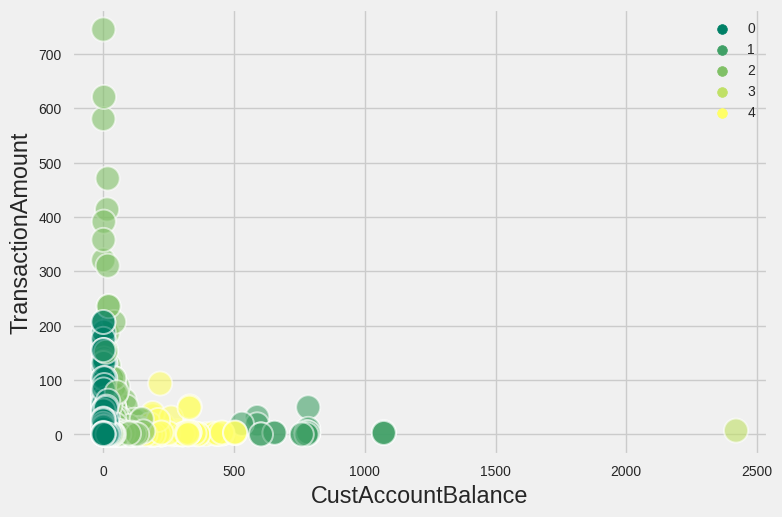

In [ ]:
sns.scatterplot(data=RFM_df_importance,x='CustAccountBalance',y='TransactionAmount',hue=model2.labels_,s=300,alpha=0.6,palette='summer')

<ipython-input-253-13b1c280d5a4>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
<ipython-input-253-13b1c280d5a4>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


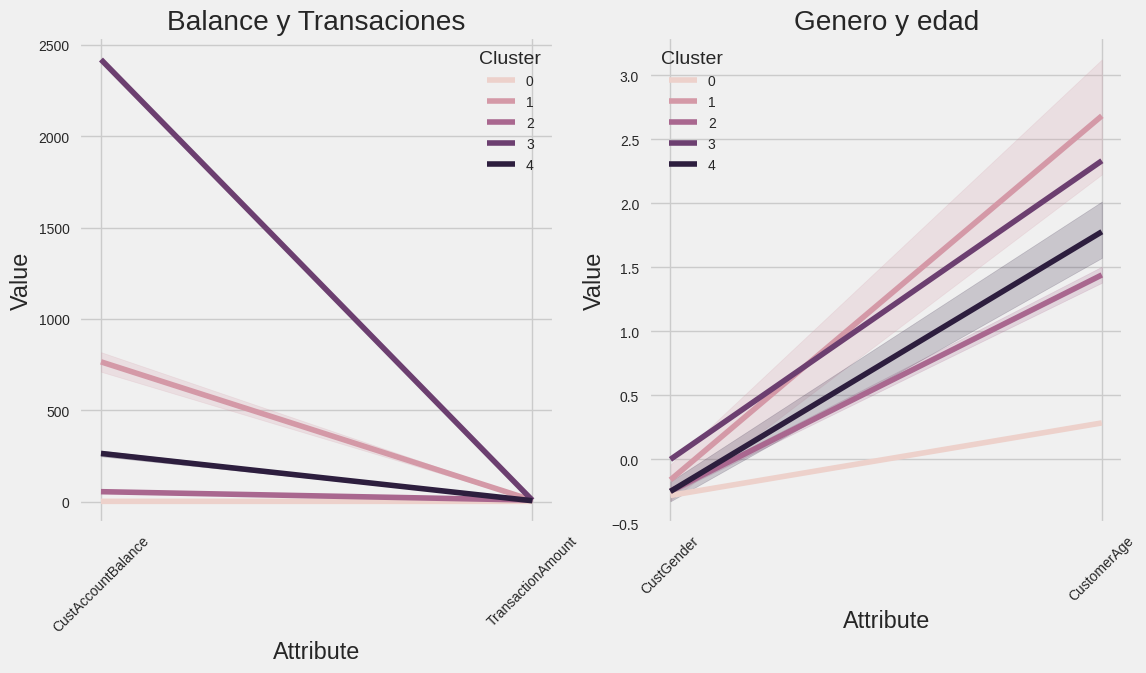

In [ ]:
def viewTheClustersKmeans5(RFM_df_kmeans5):
    """
    This function generate the plot with the clusters
    
    Args:
      df (pandas.DataFrame): DataFrame with the data used to generate the clusters.
  
    Returns:
      none
    """

    df_n = pd.DataFrame(RFM_df_kmeans5, columns=["Frequency", "CustGender", "CustLocation", "CustAccountBalance", "TransactionAmount", "CustomerAge"])

    df_n["ID"] = RFM_df_kmeans5.index
    df_n["Cluster"] = model2.labels_

    df_nor_melt = pd.melt(df_n.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=["CustAccountBalance", "TransactionAmount"],
                      var_name='Attribute',
                      value_name='Value')

    df_nor_melt2 = pd.melt(df_n.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=[ "CustGender", "CustomerAge"],
                      var_name='Attribute',
                      value_name='Value')

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_nor_melt, ax=ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_title('Balance y Transaciones')

    sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_nor_melt2, ax=ax2)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    ax2.set_title('Genero y edad')

    plt.show()

viewTheClustersKmeans5(RFM_df_kmeans5)

We see our Silhouette Score:

In [ ]:
silhouette = silhouette_score(dataframeToArray,model2.labels_)
print("Silhouette Score:",str(np.round(silhouette*100,2)) + '%')

Silhouette Score: 91.95%


The Spectral clustering algorithm has segregated the customers into five distinct groups. The **first** group comprises the dynamic customers 👥 who have lower account balance and mostly expend less cash on transactions. The **second** women between 20 and 30 who perform large-value transactions 👩🏻🛍️. The **third** man between 30 and 40 👨🏻💼 who work and keep money in their account for a possible investment.The **Four** and **Five** group includes the more conservative and money saving-minded people 🧓🏻👴🏻 who inspite of having really high account balances, spend the least amount of money in transactions, thereby judiciously maintaining their savings accounts.

## Find number of sample due to compute limitations

The method used to calculate the required sample size is called the "simple random sample formula". This formula is widely used to determine the sample size needed for a given population, and is an important tool in the design of research studies and surveys.

In [48]:
import math

def calculateSample(RFM_df_importance):
    """
    This function calculates the sample size needed based on the number of observations in the `RFM_df_importance` dataset.

    Args:
      none

    Returns:
       none
    """
    N = len(RFM_df_importance)  # n
    e = 0.01  # margen de error deseado
    n = N / (1 + N * e**2)
    n = math.ceil(n)  # round up

    print(n)  # tamaño de la muestra necesario

calculateSample(RFM_df_importance)

9883


### Hierarchical clustering

Hierarchical clustering is where you build a dendrogram to represent data, where each group links to two or more successor groups. The groups are nested and organized as a tree, which ideally ends up as a meaningful classification scheme.

Each node in the cluster tree contains a group of similar data; Nodes group on the graph next to other, similar nodes. Clusters at one level join with clusters in the next level up, using a degree of similarity. The process carries on until all nodes are in the tree, which gives a visual snapshot of the data contained in the whole set. The total number of clusters is not predetermined before you start the tree creation.

#### Hierarchical clustering based on customer's age

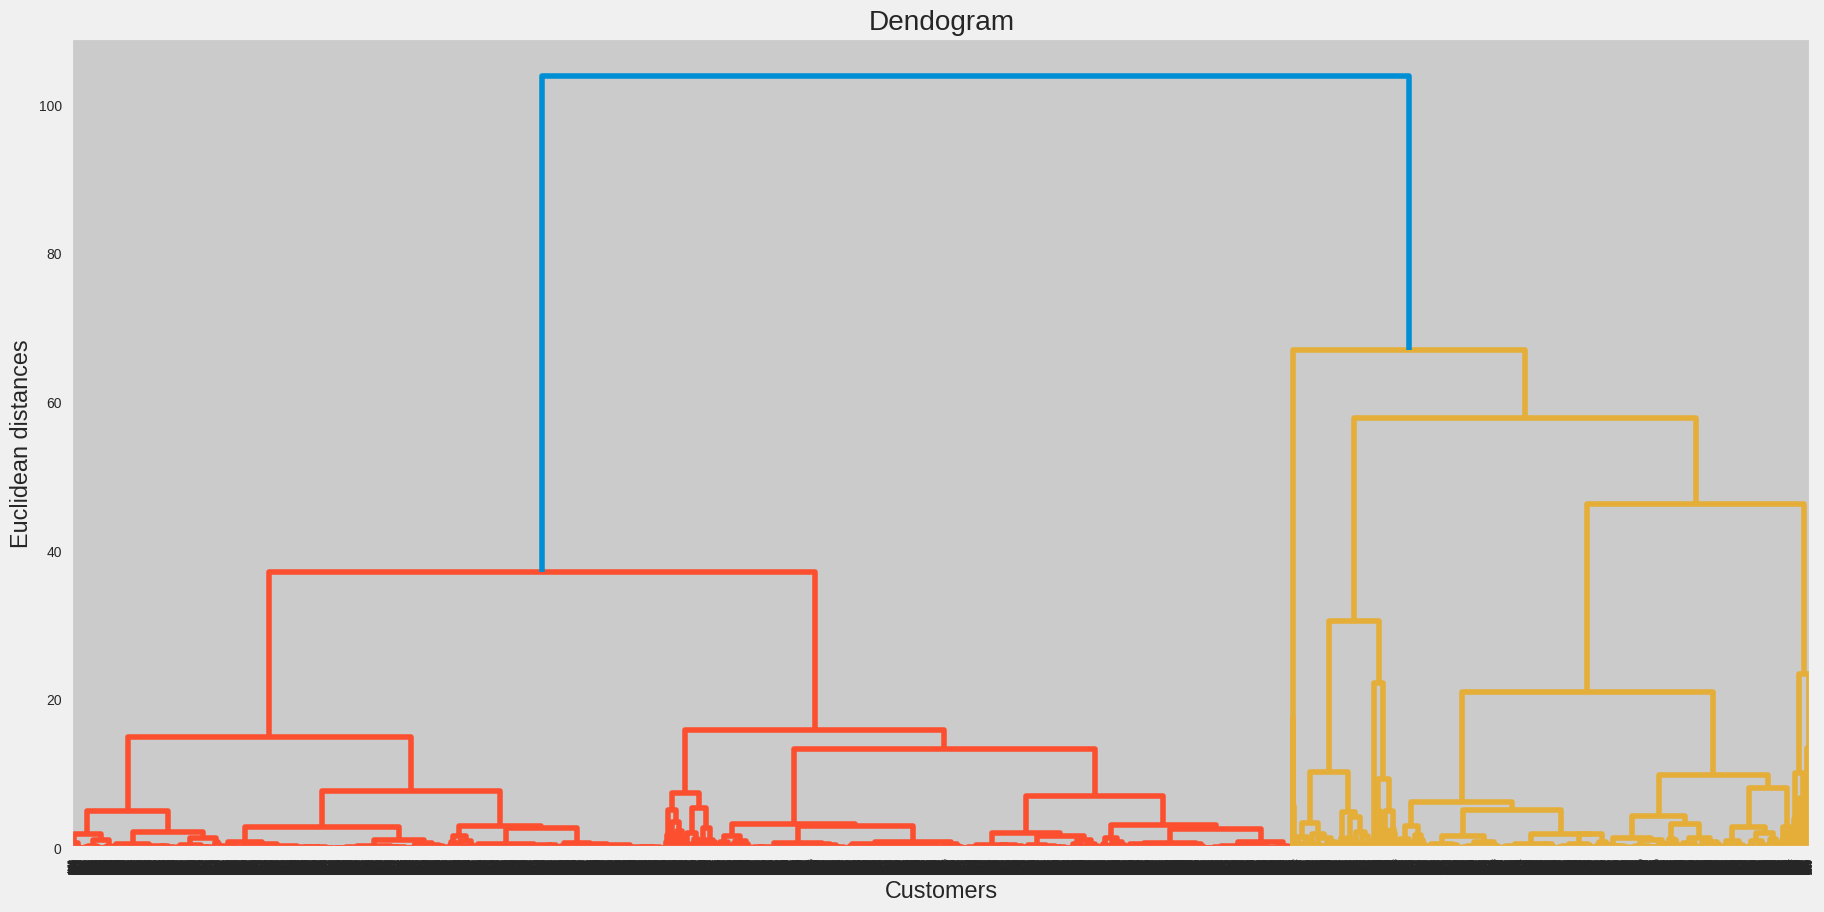

In [ ]:
import scipy.cluster.hierarchy as sch

customerAgeSample = None

def hierarchicalClusteringAge(RFM_df_importance):
    """
      Perform hierarchical clustering on the age and account balance variables in the input DataFrame using Ward's method.
    
    Args:
      RFM_df_importance : pandas DataFrame
        A DataFrame containing customer information, including the 'CustomerAge' and 'CustAccountBalance' columns.

    Returns:
      dendogram_age : dict
        A dictionary containing information about the dendrogram visualization of the hierarchical clustering. The keys are 'icoord', 'dcoord', 'leaves', and 'color_list', which correspond to the output of scipy's dendrogram function.
    """
    global customerAgeSample
    customerAgeSample = pd.DataFrame(RFM_df_importance[['CustomerAge', 'CustAccountBalance']].values).sample(10000)
    plt.figure(figsize=(20, 10))
    dendogram_age = sch.dendrogram(sch.linkage(customerAgeSample, method='ward'))
    plt.title("Dendogram")
    plt.xlabel("Customers")
    plt.ylabel("Euclidean distances")
    plt.show()
    return dendogram_age

dendogram_age = hierarchicalClusteringAge(RFM_df_importance)

In [ ]:
def getBestClustersAge(dendogram_age):
    """
    Determines the optimal number of clusters based on a dendrogram obtained through hierarchical clustering.

    Args:
      dendogram_age (dict): A dictionary containing the dendrogram information.

    Returns:
      num_clusters_age (int): The optimal number of clusters.
    """
    unique_colors_age = set(dendogram_age['color_list'])
    num_clusters_age = len(unique_colors_age)-1
    print("Optimal number of clusters is : ", num_clusters_age)
    return num_clusters_age

num_clusters_age = getBestClustersAge(dendogram_age)

Optimal number of clusters is :  2


Calculate the Estimated number of noise points

In [ ]:
cluster_age = AgglomerativeClustering(n_clusters=num_clusters_age, affinity='euclidean', linkage='ward')
cluster_age.fit_predict(customerAgeSample)
print("Estimated number of noise points:", list(cluster_age.labels_).count(-1))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Estimated number of noise points: 0


We make the scatter plot

(-0.5, 6.0)

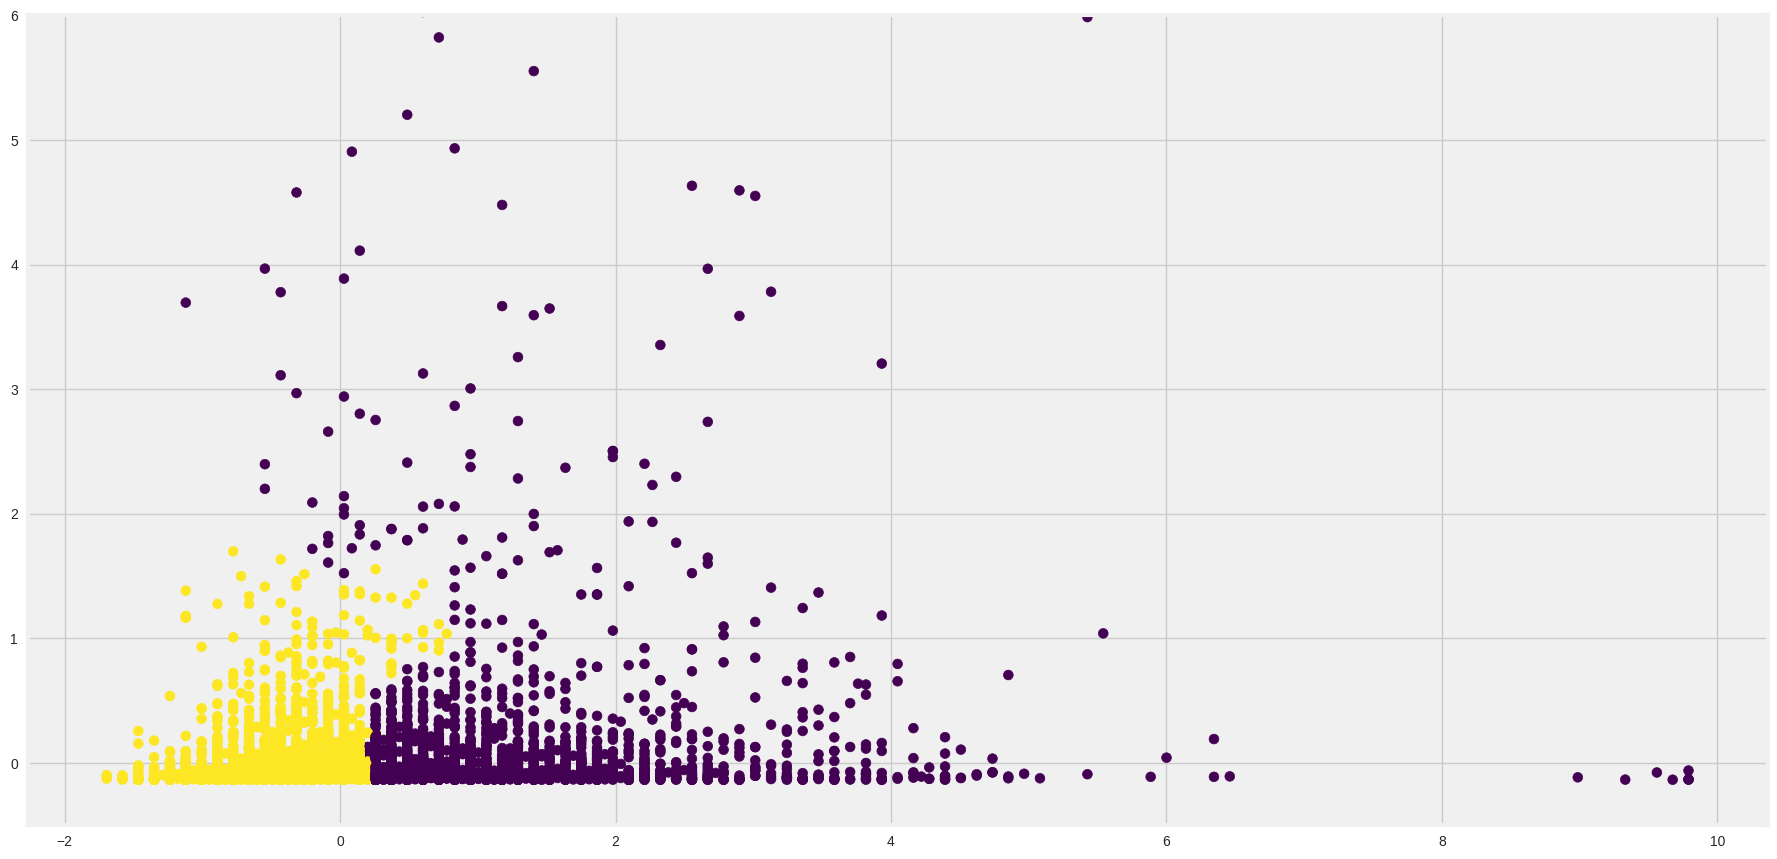

In [ ]:
plt.figure(num=None, figsize=(20, 10), facecolor='w', edgecolor='k')
plt.scatter(customerAgeSample[0], customerAgeSample[1], c=cluster_age.labels_, cmap='viridis');
plt.ylim(-0.5,6)

Now, we are going to see the Silhouette Score

In [ ]:
silhouette = silhouette_score(customerAgeSample, cluster_age.labels_)
print("Silhouette Score:", silhouette)

Silhouette Score: 0.5690559012363822


#### Hierarchical clustering based on customer's location

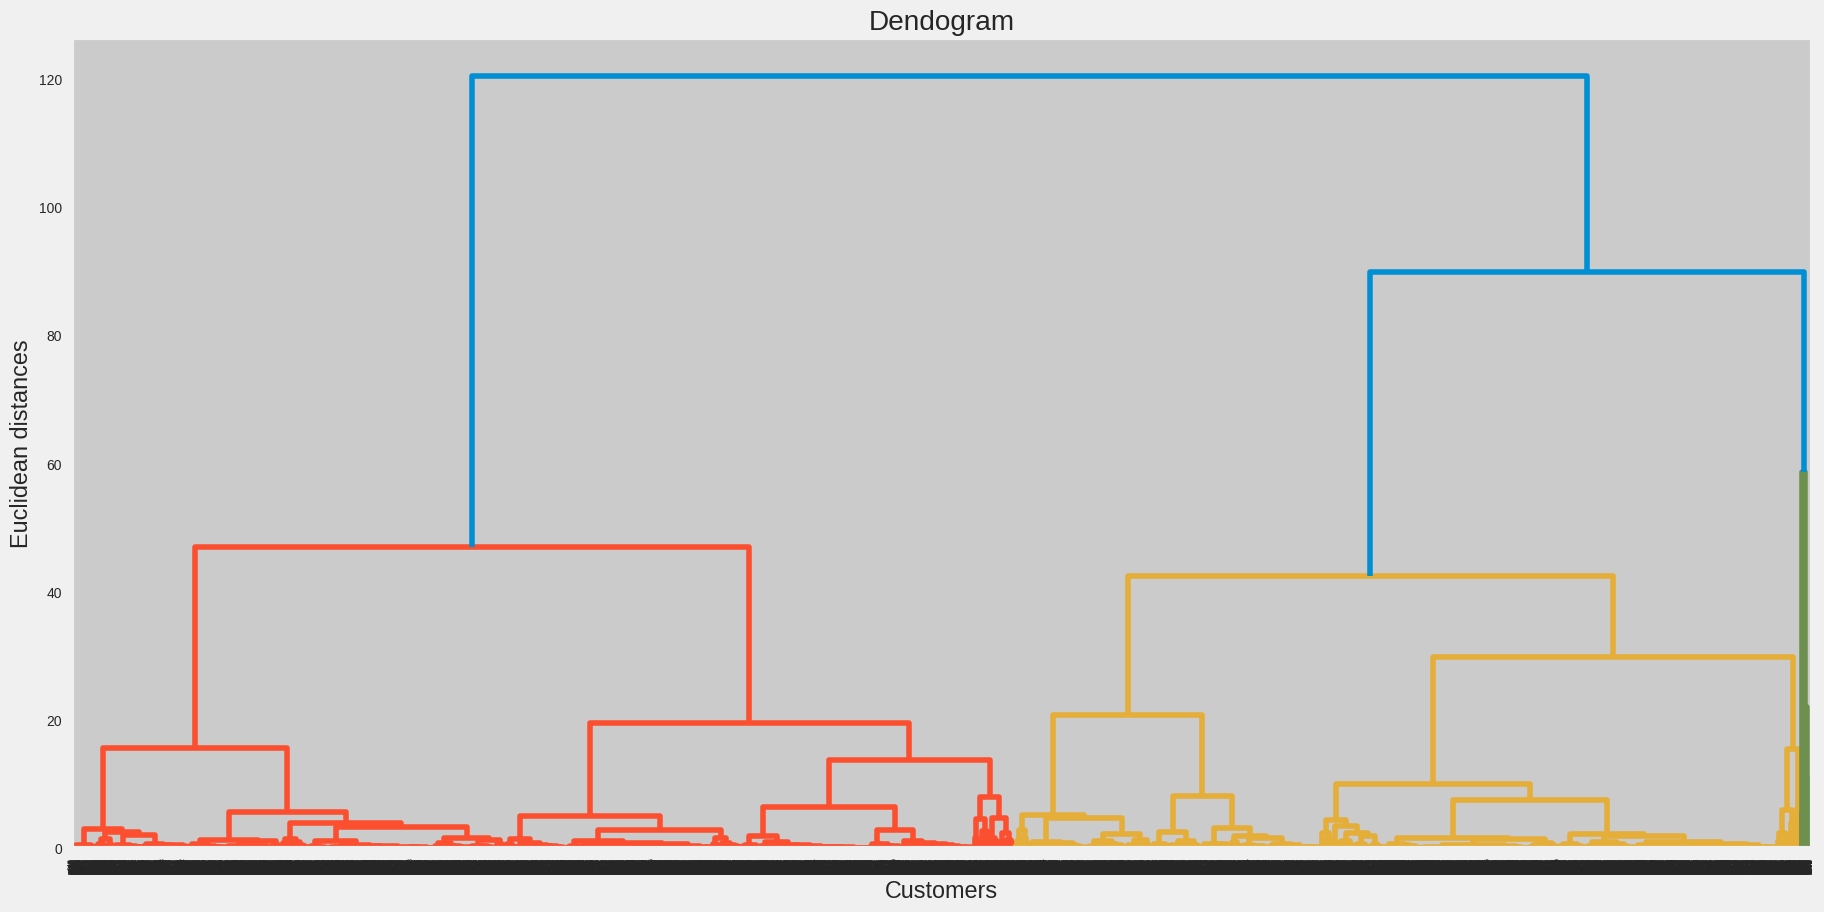

In [ ]:
customerLocationSample = None

def hierarchicalClusteringLocation(RFM_df_importance):
    """
    Perform hierarchical clustering on the age and account balance variables in the input DataFrame using Ward's method.
    
    Args:
      RFM_df_importance : pandas DataFrame
        A DataFrame containing customer information, including the 'CustomerAge' and 'CustAccountBalance' columns.

    Returns:
      dendogram_location : dict
        A dictionary containing information about the dendrogram visualization of the hierarchical clustering. The keys are 'icoord', 'dcoord', 'leaves', and 'color_list', which correspond to the output of scipy's dendrogram function.
    """
    global customerLocationSample
    customerLocationSample = pd.DataFrame(RFM_df_importance[['CustLocation', 'CustAccountBalance']].values).sample(10000)
    plt.figure(figsize=(20, 10))
    dendogram_location = sch.dendrogram(sch.linkage(customerLocationSample, method='ward'))
    plt.title("Dendogram")
    plt.xlabel("Customers")
    plt.ylabel("Euclidean distances")
    plt.show()
    return dendogram_location

dendogram_location = hierarchicalClusteringLocation(RFM_df_importance)

In [ ]:
def getBestClustersLocation(dendogram_location):
    """
    Determines the optimal number of clusters based on a dendrogram obtained through hierarchical clustering.

    Args:
      dendogram_location (dict): A dictionary containing the dendrogram information.

    Returns:
      num_clusters_location (int): The optimal number of clusters.
    """
    unique_colors_location = set(dendogram_location['color_list'])
    num_clusters_location = len(unique_colors_location)-1
    print("Optimal number of clusters is : ", num_clusters_location)
    return num_clusters_location

num_clusters_location = getBestClustersLocation(dendogram_location)

Optimal number of clusters is :  3


In [ ]:
cluster_location = AgglomerativeClustering(n_clusters=num_clusters_location, affinity='euclidean', linkage='ward')
cluster_location.fit_predict(customerLocationSample)
print("Estimated number of noise points:", list(cluster_location.labels_).count(-1))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Estimated number of noise points: 0


We make the scatter plot

(-0.5, 6.0)

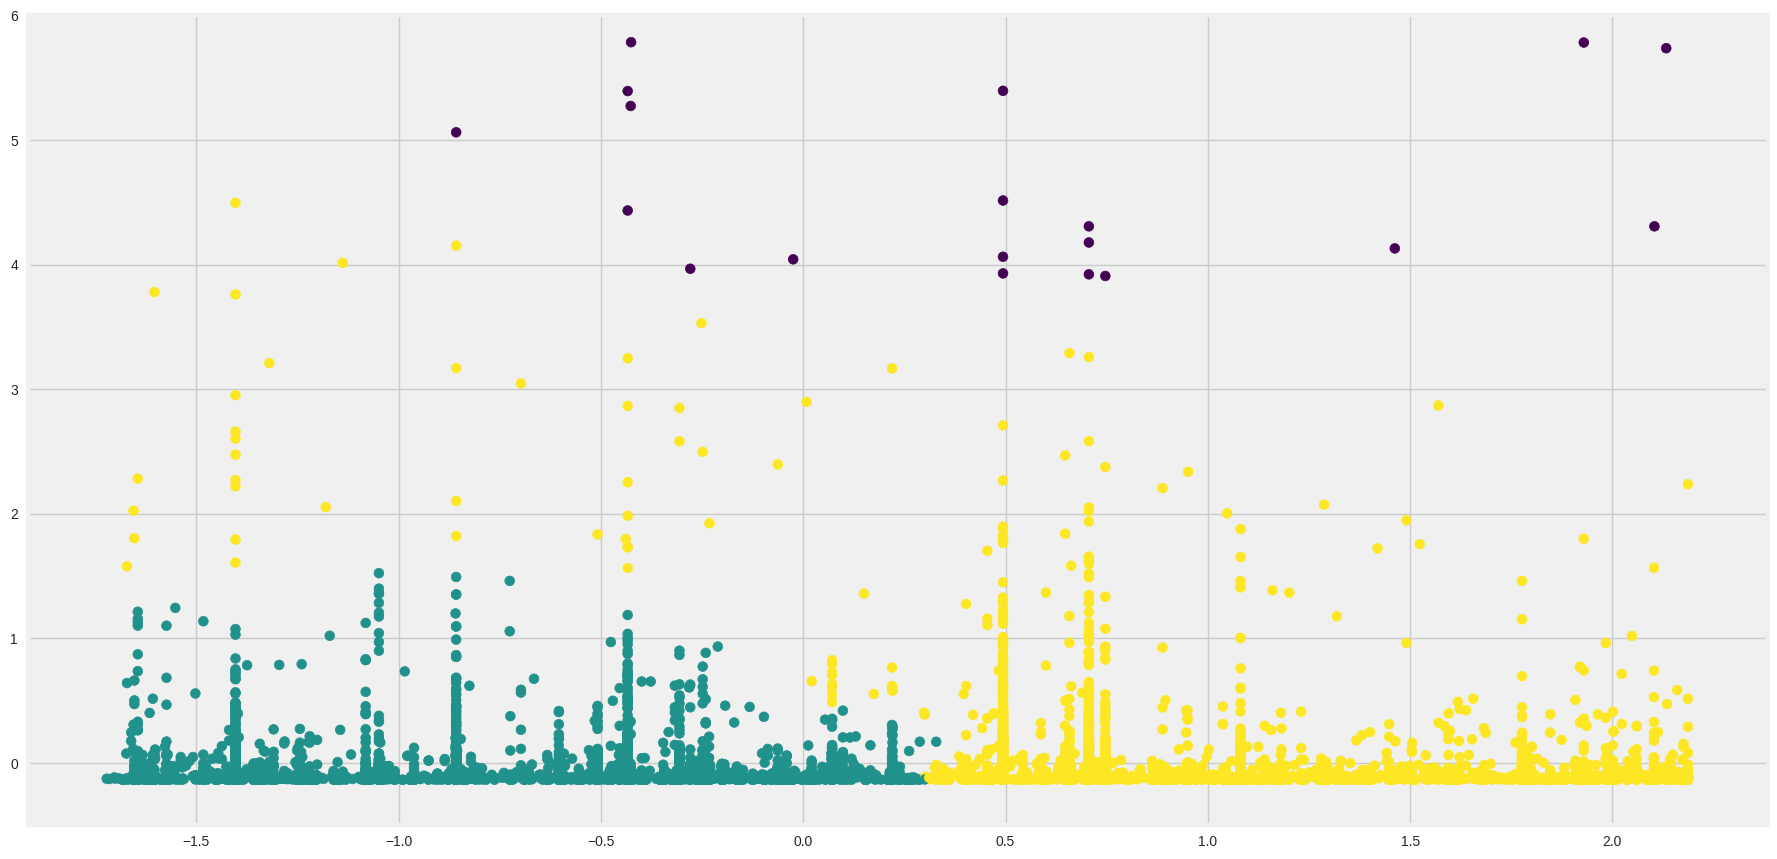

In [ ]:
plt.figure(num=None, figsize=(20, 10), facecolor='w', edgecolor='k')
plt.scatter(customerLocationSample[0], customerLocationSample[1], c=cluster_location.labels_, cmap='viridis');
plt.ylim(-0.5,6)

We get our Silhouette Score, this score is better than the score of the age clusters

In [ ]:
silhouette = silhouette_score(customerLocationSample, cluster_location.labels_)
print("Silhouette Score:", silhouette)

Silhouette Score: 0.5947098347211797


### DBSCAN

#### Key Characteristics of DBSCAN Algorithm
- It does not require the number of clusters as input.
- It is can detect outliers while finding clusters.
- DBSCAN algorithm can detect clusters that are complex or randomly shaped and sized.

In case you do not have the Kneed and Clusteval libraries, this code installs them.

In [ ]:
!pip install kneed
!pip install clusteval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
temp= RFM_df_importance.sample(10000)

def dbscanInitial(temp):
    """
    Performs DBSCAN clustering on a sample of data using the default settings.

    Args:
      temp: pandas DataFrame
        The DataFrame containing the data to be clustered.

    Returns:
      None
    """
    base_dbscan = DBSCAN()
    base_dbscan.fit(temp) # Review
    print("Estimated number of clusters:", set(base_dbscan.labels_))
    print("Estimated number of noise points:", list(base_dbscan.labels_).count(-1))

dbscanInitial(temp)

Estimated number of clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -1}
Estimated number of noise points: 527


We do the dbscan initially without having the hyperparameters well defined, this is to give us an overview of how good the model is, in the Silhouette score we can see that it is very low, so we proceed to look for the best hyperparameters.

In [ ]:
print("Silhouette Score:", str(np.round(silhouette_score(temp, base_dbscan.labels_) * 100, 2)) + '%')

Silhouette Score: 26.83%


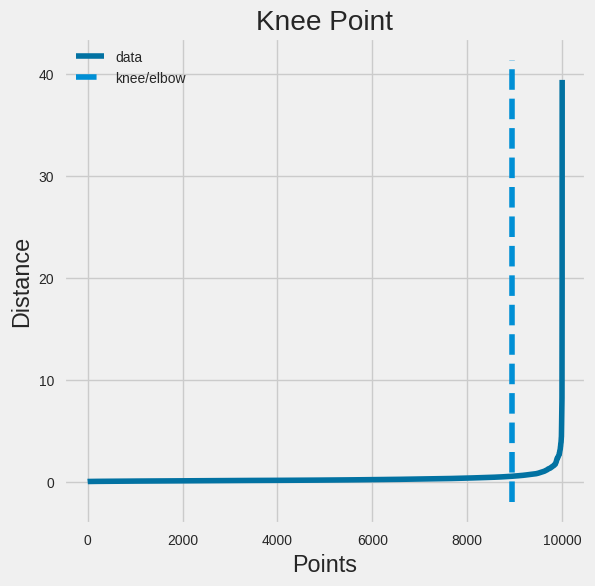

Knee Point: 0.5333854057269539


In [ ]:
from kneed import KneeLocator

def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):
    """
    Plots the k-distance graph for a given dataset and returns the distance value at the knee point.

    Args:
        X (numpy array or pandas DataFrame): The input dataset.
        k (int): The number of neighbors to consider.
        radius_nbrs (float): The radius of neighbors to consider.

    Returns:
        float: The distance value at the knee point.

    Raises:
        ValueError: If the input dataset is empty or the number of neighbors is negative.
    """
    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)
    distances, indices = nbrs.kneighbors(X)                          
    distances = np.sort(distances[:,k-1], axis=0)
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    knee.plot_knee()
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.show()
    return distances[knee.knee]
  
k = 2 * temp.shape[-1] 
x = get_kdist_plot(temp,k)
print("Knee Point:",x)

In [ ]:
def calculateMinimumSamples(x):
    """
    Calculates the minimum number of samples required for DBSCAN clustering by evaluating the silhouette score
    for different values of the minimum number of samples parameter.
    
    Args:
      x: float
        The distance threshold value for DBSCAN clustering.

    Returns:
      None
    """
    ms = np.arange(3,2*temp.shape[1],3)
    silhouette_scores = []

    for i in ms:
      dbscan = DBSCAN(eps=x,min_samples=i)
      dbscan.fit(temp)
      silhouette_scores.append(silhouette_score(temp,dbscan.labels_))
      print("{} Minimum Samples Tested!".format(i))

    plt.figure(figsize=(8,4),dpi=150)
    sns.lineplot(x=ms,y=silhouette_scores)
    plt.xlabel('Minimum Number of Samples')
    plt.ylabel('Silhouette Score')
    
calculateMinimumSamples(x)

3 Minimum Samples Tested!
6 Minimum Samples Tested!
9 Minimum Samples Tested!


Now, let's see the best Silhouette score for each sample, we can conclude that the best min_samples is 6

Text(0, 0.5, 'Silhouette Score')

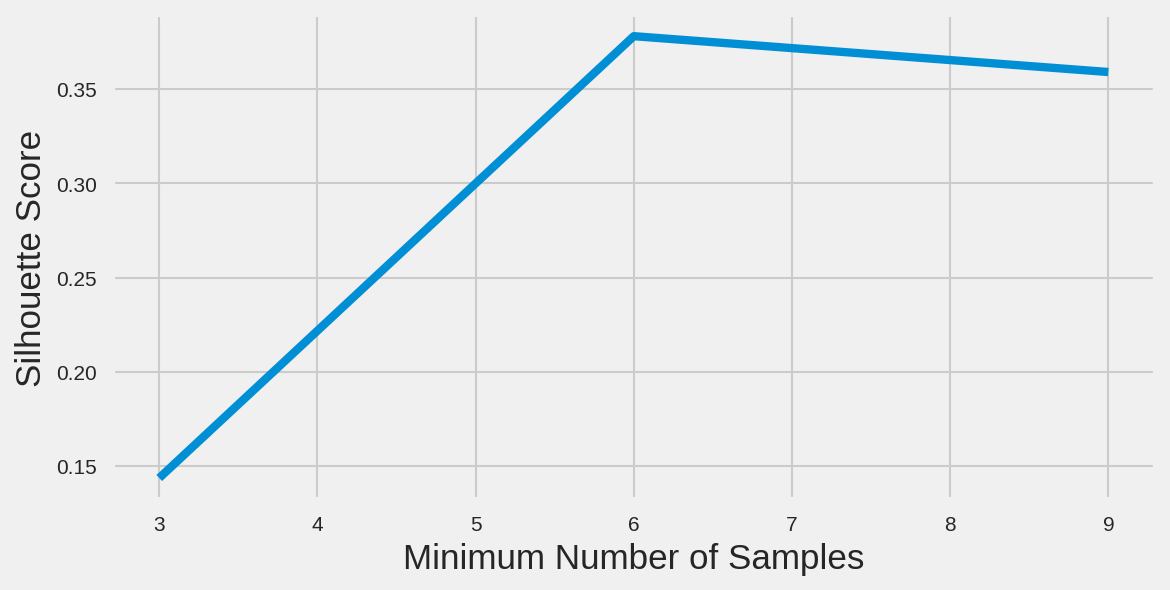

In [ ]:
def optimizedDbscan(x):
    """
    Apply DBSCAN algorithm to cluster data using the input value for epsilon (eps) and a minimum of 6 samples for each cluster.

    Args:
        x (float): The value of epsilon (eps) to use for DBSCAN clustering.

    Returns:
        optimized_dbscan (DBSCAN object): An instance of the DBSCAN algorithm with the specified parameters fit to the input data.
    """
    optimized_dbscan = DBSCAN(eps=x,min_samples=6)
    optimized_dbscan.fit(temp)
    print("Estimated number of clusters:",set(optimized_dbscan.labels_))
    print("Estimated number of noise points:",list(optimized_dbscan.labels_).count(-1))
    print("Silhouette Score:",str(np.round(silhouette_score(temp,optimized_dbscan.labels_)*100,2)) + '%')

    return optimized_dbscan

optimized_dbscan = optimizedDbscan(x)

Estimated number of clusters: {0, 1, 2, 3, 4, 5, 6, -1}
Estimated number of noise points: 517
Silhouette Score: 37.8%


<Axes: xlabel='CustAccountBalance', ylabel='TransactionAmount'>

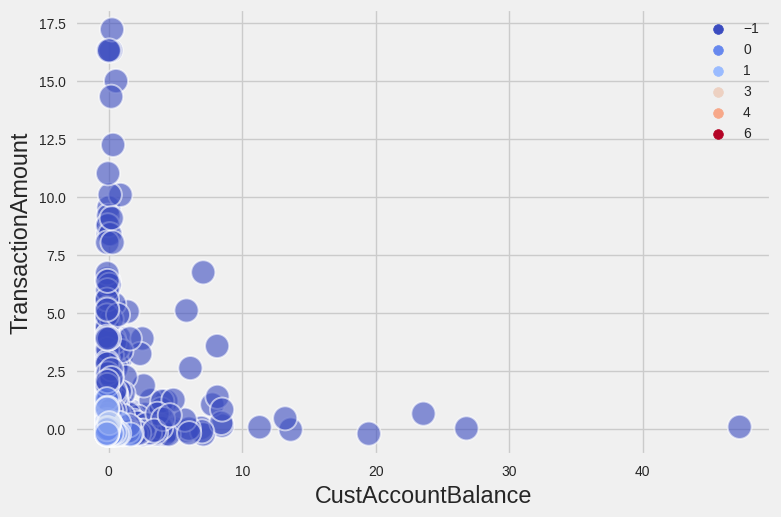

In [ ]:
sns.scatterplot(data=temp, x='CustAccountBalance',y='TransactionAmount',hue=optimized_dbscan.labels_,s=300,alpha=0.6,palette='coolwarm')

Once we found the best number of samples, in this case 6, we proceeded to run the model again and found that the Silhouette Score increased from 25% to 37%, however we have not yet finished optimizing the model.

Next we are going to find the best value of epsilon

In [ ]:
from clusteval import clusteval
temp= temp.sample(500)

def optDbscanClusteval(temp):
    """
    Evaluates optimal number of clusters for DBSCAN clustering algorithm using clusteval library on input data.
    
    Args:
        temp : numpy array or pandas DataFrame
            A dataset of input features to be clustered using DBSCAN algorithm.

    Returns:
        ce : clusteval object
            An object of the clusteval library containing clustering evaluation results.
    """
    ce = clusteval(cluster='dbscan', verbose=3)
    results = ce.fit(np.reshape(np.ravel(temp),(-1,1)))
    cluster_labels = results['labx']
    print("Distinct Cluster Labels Detected:", np.unique(cluster_labels))
    return ce

ce = optDbscanClusteval(temp)

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[dbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Gridsearch across Epsilon.
[clusteval] >INFO> Evaluate using silhouette..
[clusteval] >INFO: 100%|██████████| 245/245 [01:35<00:00,  2.57it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.


Distinct Cluster Labels Detected: [-1  0]


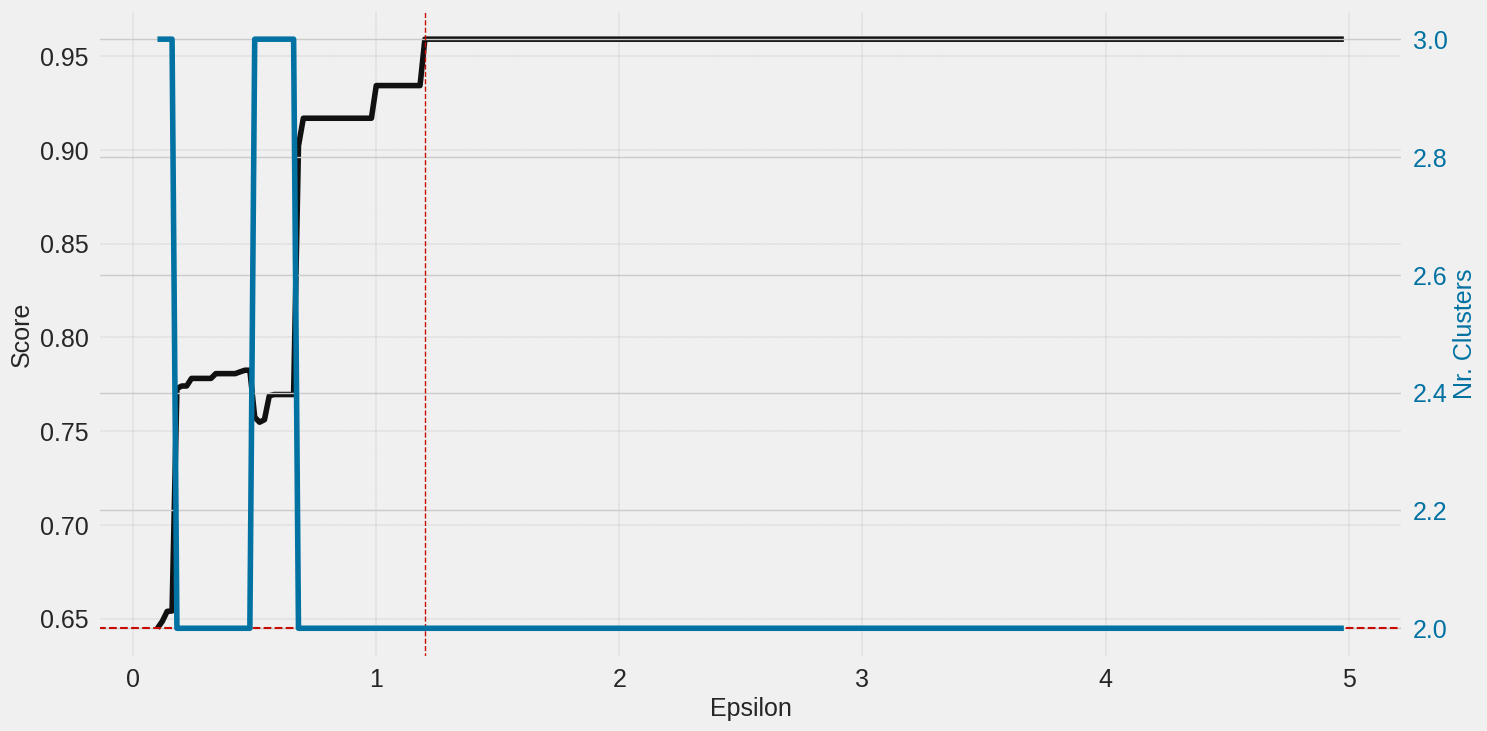

(<Figure size 1500x800 with 2 Axes>,
 (<Axes: xlabel='Epsilon', ylabel='Score'>, <Axes: ylabel='Nr. Clusters'>))

In [ ]:
ce.plot()

We can now see that the best epsilon is equal to 3, we proceed to train our new model with the optimized values

In [ ]:
def enhancedDbscan(temp):
    """
    Perform density-based clustering using DBSCAN with an enhanced hyperparameter setting.

    Args:
        temp (pandas.DataFrame): A DataFrame containing the data to be clustered.

    Returns:
        enenhanced_dbscan (sklearn.cluster.DBSCAN): A DBSCAN object that has been fit to the data.
    """
    enhanced_dbscan = DBSCAN(eps=3,min_samples=2*temp.shape[1])
    enhanced_dbscan.fit(temp)
    print("Estimated number of clusters:",len(set(enhanced_dbscan.labels_)),set(enhanced_dbscan.labels_))
    return enhanced_dbscan

enhanced_dbscan = enhancedDbscan(temp)

Estimated number of clusters: 2 {0, -1}


<Axes: xlabel='CustAccountBalance', ylabel='TransactionAmount'>

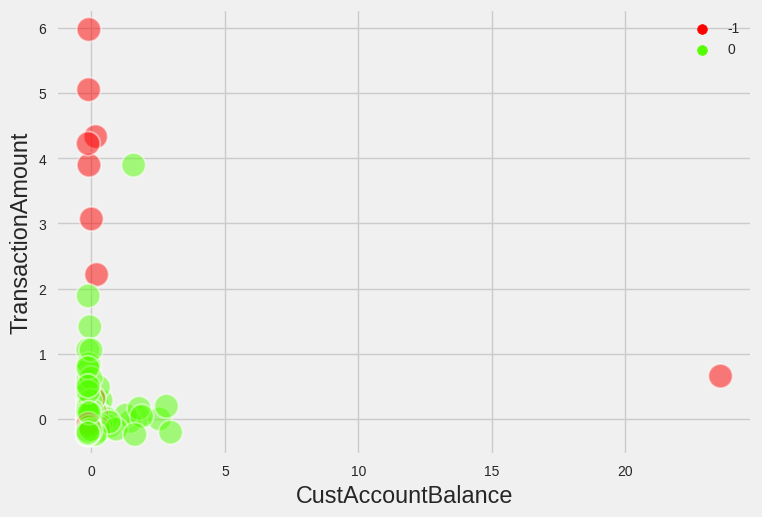

In [ ]:
sns.scatterplot(data=temp,x='CustAccountBalance',y='TransactionAmount',hue=enhanced_dbscan.labels_,palette='prism',s=300,alpha=0.5)

In [ ]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,enhanced_dbscan.labels_)*100,2)) + '%')

Silhouette Score: 56.73%


The optimized DBSCAN model has classified the entire population of customers primarily into two major groups, one of them consists of all those customers who have modest account balance and make low-value transactions whereas the miscellaneous group includes either the customers who have high account balances and spend very less money through transactions or those who have minimal account balance but expend a large amount of cash through high-value transactions.

